In [ ]:
import numpy as np
import os
import cv2
from tqdm import tqdm
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [ ]:
!unzip /content/drive/MyDrive/dataset.zip

In [ ]:
labels = ['no','sphere','vort']

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.file_paths = []
        self.labels = []

        for i, cls in enumerate(self.classes):
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                files = os.listdir(cls_dir)
                for file in files:
                    self.file_paths.append(os.path.join(cls_dir, file))
                    self.labels.append(i-1)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        image = np.load(img_path)
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
dataset_path = '/content/dataset'


train_dataset = CustomDataset(root_dir=os.path.join(dataset_path, 'train'), transform=None)
train_batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)


val_dataset = CustomDataset(root_dir=os.path.join(dataset_path, 'val'), transform=None)
val_batch_size = 64
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetSmall(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNetSmall, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self.make_layer(32, 32, 2)
        self.layer2 = self.make_layer(32, 64, 2, stride=2)
        self.layer3 = self.make_layer(64, 64, 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2, 2)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.softmax(out, dim=1)

# Instantiate the model
model = ResNetSmall(num_classes=3)
model =  model.float()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

ResNetSmall(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
num_epoch  = 15

for epoch in tqdm(range(num_epoch)):
  training_loss = 0.0
  for i, data in enumerate(tqdm(train_dataloader),0):
    train_img, train_labels = data
    train_img, train_labels = train_img.to(device), train_labels.to(device)
    optimizer.zero_grad()
    outputs = model(train_img.float())
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()
    training_loss+= loss.item()
    if i % 5 == 0:
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, training_loss / 5))
      training_loss = 0.0

print("Training Finished")

  0%|          | 2/469 [00:01<04:16,  1.82it/s]

[1,     1] loss: 0.221



  1%|▏         | 7/469 [00:02<01:29,  5.15it/s]

[1,     6] loss: 1.102



  3%|▎         | 12/469 [00:02<01:13,  6.21it/s]

[1,    11] loss: 1.097



  4%|▎         | 17/469 [00:03<01:09,  6.49it/s]

[1,    16] loss: 1.097



  5%|▍         | 22/469 [00:04<01:07,  6.65it/s]

[1,    21] loss: 1.098



  6%|▌         | 27/469 [00:05<01:04,  6.80it/s]

[1,    26] loss: 1.100



  7%|▋         | 32/469 [00:05<01:05,  6.69it/s]

[1,    31] loss: 1.101



  8%|▊         | 37/469 [00:06<01:03,  6.78it/s]

[1,    36] loss: 1.098



  9%|▉         | 42/469 [00:07<01:03,  6.75it/s]

[1,    41] loss: 1.099



 10%|█         | 47/469 [00:08<01:02,  6.74it/s]

[1,    46] loss: 1.095



 11%|█         | 52/469 [00:08<01:01,  6.74it/s]

[1,    51] loss: 1.102



 12%|█▏        | 57/469 [00:09<01:01,  6.68it/s]

[1,    56] loss: 1.097



 13%|█▎        | 62/469 [00:10<01:00,  6.72it/s]

[1,    61] loss: 1.105



 14%|█▍        | 67/469 [00:11<01:00,  6.64it/s]

[1,    66] loss: 1.096



 15%|█▌        | 72/469 [00:11<00:58,  6.76it/s]

[1,    71] loss: 1.101



 16%|█▋        | 77/469 [00:12<00:58,  6.66it/s]

[1,    76] loss: 1.106



 17%|█▋        | 82/469 [00:13<00:57,  6.67it/s]

[1,    81] loss: 1.098



 19%|█▊        | 87/469 [00:14<00:59,  6.47it/s]

[1,    86] loss: 1.107



 20%|█▉        | 92/469 [00:14<00:57,  6.50it/s]

[1,    91] loss: 1.104



 21%|██        | 97/469 [00:15<00:57,  6.51it/s]

[1,    96] loss: 1.103



 22%|██▏       | 102/469 [00:16<00:59,  6.21it/s]

[1,   101] loss: 1.099



 23%|██▎       | 107/469 [00:17<00:54,  6.61it/s]

[1,   106] loss: 1.090



 24%|██▍       | 112/469 [00:17<00:53,  6.65it/s]

[1,   111] loss: 1.104



 25%|██▍       | 117/469 [00:18<00:52,  6.72it/s]

[1,   116] loss: 1.105



 26%|██▌       | 122/469 [00:19<00:52,  6.67it/s]

[1,   121] loss: 1.104



 27%|██▋       | 127/469 [00:20<00:51,  6.67it/s]

[1,   126] loss: 1.098



 28%|██▊       | 132/469 [00:20<00:50,  6.62it/s]

[1,   131] loss: 1.103



 29%|██▉       | 137/469 [00:21<00:49,  6.69it/s]

[1,   136] loss: 1.100



 30%|███       | 142/469 [00:22<00:48,  6.69it/s]

[1,   141] loss: 1.096



 31%|███▏      | 147/469 [00:23<00:48,  6.70it/s]

[1,   146] loss: 1.102



 32%|███▏      | 152/469 [00:23<00:47,  6.69it/s]

[1,   151] loss: 1.095



 33%|███▎      | 157/469 [00:24<00:46,  6.71it/s]

[1,   156] loss: 1.098



 35%|███▍      | 162/469 [00:25<00:45,  6.71it/s]

[1,   161] loss: 1.098



 36%|███▌      | 167/469 [00:26<00:45,  6.70it/s]

[1,   166] loss: 1.102



 37%|███▋      | 172/469 [00:26<00:46,  6.45it/s]

[1,   171] loss: 1.100



 38%|███▊      | 177/469 [00:27<00:46,  6.32it/s]

[1,   176] loss: 1.095



 39%|███▉      | 182/469 [00:28<00:44,  6.39it/s]

[1,   181] loss: 1.103



 40%|███▉      | 187/469 [00:29<00:43,  6.53it/s]

[1,   186] loss: 1.102



 41%|████      | 192/469 [00:29<00:41,  6.61it/s]

[1,   191] loss: 1.096



 42%|████▏     | 197/469 [00:30<00:40,  6.69it/s]

[1,   196] loss: 1.104



 43%|████▎     | 202/469 [00:31<00:39,  6.74it/s]

[1,   201] loss: 1.099



 44%|████▍     | 207/469 [00:32<00:39,  6.64it/s]

[1,   206] loss: 1.095



 45%|████▌     | 212/469 [00:32<00:39,  6.53it/s]

[1,   211] loss: 1.093



 46%|████▋     | 217/469 [00:33<00:38,  6.61it/s]

[1,   216] loss: 1.099



 47%|████▋     | 222/469 [00:34<00:37,  6.64it/s]

[1,   221] loss: 1.102



 48%|████▊     | 227/469 [00:35<00:36,  6.67it/s]

[1,   226] loss: 1.094



 49%|████▉     | 232/469 [00:35<00:35,  6.65it/s]

[1,   231] loss: 1.102



 51%|█████     | 237/469 [00:36<00:34,  6.73it/s]

[1,   236] loss: 1.104



 52%|█████▏    | 242/469 [00:37<00:33,  6.69it/s]

[1,   241] loss: 1.097



 53%|█████▎    | 247/469 [00:38<00:34,  6.53it/s]

[1,   246] loss: 1.099



 54%|█████▎    | 252/469 [00:39<00:32,  6.61it/s]

[1,   251] loss: 1.100



 55%|█████▍    | 257/469 [00:39<00:32,  6.55it/s]

[1,   256] loss: 1.097



 56%|█████▌    | 262/469 [00:40<00:33,  6.18it/s]

[1,   261] loss: 1.093



 57%|█████▋    | 267/469 [00:41<00:32,  6.14it/s]

[1,   266] loss: 1.097



 58%|█████▊    | 272/469 [00:42<00:30,  6.38it/s]

[1,   271] loss: 1.101



 59%|█████▉    | 277/469 [00:42<00:29,  6.45it/s]

[1,   276] loss: 1.098



 60%|██████    | 282/469 [00:43<00:28,  6.54it/s]

[1,   281] loss: 1.106



 61%|██████    | 287/469 [00:44<00:27,  6.62it/s]

[1,   286] loss: 1.096



 62%|██████▏   | 292/469 [00:45<00:27,  6.51it/s]

[1,   291] loss: 1.097



 63%|██████▎   | 297/469 [00:45<00:25,  6.63it/s]

[1,   296] loss: 1.093



 64%|██████▍   | 302/469 [00:46<00:25,  6.57it/s]

[1,   301] loss: 1.099



 65%|██████▌   | 307/469 [00:47<00:24,  6.68it/s]

[1,   306] loss: 1.098



 67%|██████▋   | 312/469 [00:48<00:23,  6.63it/s]

[1,   311] loss: 1.102



 68%|██████▊   | 317/469 [00:49<00:23,  6.52it/s]

[1,   316] loss: 1.100



 69%|██████▊   | 322/469 [00:49<00:22,  6.51it/s]

[1,   321] loss: 1.099



 70%|██████▉   | 327/469 [00:50<00:21,  6.54it/s]

[1,   326] loss: 1.096



 71%|███████   | 332/469 [00:51<00:20,  6.67it/s]

[1,   331] loss: 1.102



 72%|███████▏  | 337/469 [00:52<00:19,  6.71it/s]

[1,   336] loss: 1.101



 73%|███████▎  | 342/469 [00:52<00:19,  6.60it/s]

[1,   341] loss: 1.101



 74%|███████▍  | 347/469 [00:53<00:19,  6.32it/s]

[1,   346] loss: 1.099



 75%|███████▌  | 352/469 [00:54<00:18,  6.46it/s]

[1,   351] loss: 1.097



 76%|███████▌  | 357/469 [00:55<00:17,  6.34it/s]

[1,   356] loss: 1.097



 77%|███████▋  | 362/469 [00:55<00:16,  6.36it/s]

[1,   361] loss: 1.107



 78%|███████▊  | 367/469 [00:56<00:15,  6.39it/s]

[1,   366] loss: 1.098



 79%|███████▉  | 372/469 [00:57<00:14,  6.58it/s]

[1,   371] loss: 1.101



 80%|████████  | 377/469 [00:58<00:13,  6.58it/s]

[1,   376] loss: 1.096



 81%|████████▏ | 382/469 [00:58<00:13,  6.61it/s]

[1,   381] loss: 1.103



 83%|████████▎ | 387/469 [00:59<00:12,  6.62it/s]

[1,   386] loss: 1.101



 84%|████████▎ | 392/469 [01:00<00:11,  6.56it/s]

[1,   391] loss: 1.099



 85%|████████▍ | 397/469 [01:01<00:10,  6.55it/s]

[1,   396] loss: 1.097



 86%|████████▌ | 402/469 [01:02<00:10,  6.48it/s]

[1,   401] loss: 1.097



 87%|████████▋ | 407/469 [01:02<00:09,  6.45it/s]

[1,   406] loss: 1.102



 88%|████████▊ | 412/469 [01:03<00:08,  6.59it/s]

[1,   411] loss: 1.098



 89%|████████▉ | 417/469 [01:04<00:07,  6.57it/s]

[1,   416] loss: 1.101



 90%|████████▉ | 422/469 [01:05<00:07,  6.50it/s]

[1,   421] loss: 1.102



 91%|█████████ | 427/469 [01:05<00:06,  6.57it/s]

[1,   426] loss: 1.097



 92%|█████████▏| 432/469 [01:06<00:05,  6.56it/s]

[1,   431] loss: 1.097



 93%|█████████▎| 437/469 [01:07<00:05,  6.34it/s]

[1,   436] loss: 1.104



 94%|█████████▍| 442/469 [01:08<00:04,  6.24it/s]

[1,   441] loss: 1.099



 95%|█████████▌| 447/469 [01:09<00:03,  6.29it/s]

[1,   446] loss: 1.093



 96%|█████████▋| 452/469 [01:09<00:02,  6.14it/s]

[1,   451] loss: 1.098



 97%|█████████▋| 457/469 [01:10<00:01,  6.36it/s]

[1,   456] loss: 1.103



 99%|█████████▊| 462/469 [01:11<00:01,  6.46it/s]

[1,   461] loss: 1.102



100%|█████████▉| 467/469 [01:12<00:00,  6.48it/s]

[1,   466] loss: 1.097



  0%|          | 2/469 [00:00<01:10,  6.61it/s]

[2,     1] loss: 0.220



  1%|▏         | 7/469 [00:01<01:10,  6.52it/s]

[2,     6] loss: 1.104



  3%|▎         | 12/469 [00:01<01:10,  6.45it/s]

[2,    11] loss: 1.105



  4%|▎         | 17/469 [00:02<01:08,  6.60it/s]

[2,    16] loss: 1.098



  5%|▍         | 22/469 [00:03<01:07,  6.59it/s]

[2,    21] loss: 1.097



  6%|▌         | 27/469 [00:04<01:07,  6.54it/s]

[2,    26] loss: 1.094



  7%|▋         | 32/469 [00:04<01:06,  6.59it/s]

[2,    31] loss: 1.100



  8%|▊         | 37/469 [00:05<01:05,  6.57it/s]

[2,    36] loss: 1.109



  9%|▉         | 42/469 [00:06<01:05,  6.51it/s]

[2,    41] loss: 1.099



 10%|█         | 47/469 [00:07<01:04,  6.57it/s]

[2,    46] loss: 1.104



 11%|█         | 52/469 [00:07<01:05,  6.37it/s]

[2,    51] loss: 1.101



 12%|█▏        | 57/469 [00:08<01:06,  6.18it/s]

[2,    56] loss: 1.106



 13%|█▎        | 62/469 [00:09<01:04,  6.27it/s]

[2,    61] loss: 1.099



 14%|█▍        | 67/469 [00:10<01:04,  6.24it/s]

[2,    66] loss: 1.101



 15%|█▌        | 72/469 [00:11<01:04,  6.17it/s]

[2,    71] loss: 1.100



 16%|█▋        | 77/469 [00:11<01:00,  6.43it/s]

[2,    76] loss: 1.101



 17%|█▋        | 82/469 [00:12<00:58,  6.58it/s]

[2,    81] loss: 1.101



 19%|█▊        | 87/469 [00:13<00:58,  6.50it/s]

[2,    86] loss: 1.100



 20%|█▉        | 92/469 [00:14<00:58,  6.42it/s]

[2,    91] loss: 1.093



 21%|██        | 97/469 [00:15<00:57,  6.44it/s]

[2,    96] loss: 1.103



 22%|██▏       | 102/469 [00:15<00:57,  6.39it/s]

[2,   101] loss: 1.101



 23%|██▎       | 107/469 [00:16<00:54,  6.59it/s]

[2,   106] loss: 1.096



 24%|██▍       | 112/469 [00:17<00:55,  6.41it/s]

[2,   111] loss: 1.103



 25%|██▍       | 117/469 [00:18<00:54,  6.41it/s]

[2,   116] loss: 1.107



 26%|██▌       | 122/469 [00:18<00:53,  6.48it/s]

[2,   121] loss: 1.099



 27%|██▋       | 127/469 [00:19<00:52,  6.50it/s]

[2,   126] loss: 1.098



 28%|██▊       | 132/469 [00:20<00:51,  6.50it/s]

[2,   131] loss: 1.104



 29%|██▉       | 137/469 [00:21<00:51,  6.40it/s]

[2,   136] loss: 1.107



 30%|███       | 142/469 [00:22<00:52,  6.22it/s]

[2,   141] loss: 1.092



 31%|███▏      | 147/469 [00:22<00:51,  6.25it/s]

[2,   146] loss: 1.095



 32%|███▏      | 152/469 [00:23<00:51,  6.21it/s]

[2,   151] loss: 1.108



 33%|███▎      | 157/469 [00:24<00:49,  6.26it/s]

[2,   156] loss: 1.108



 35%|███▍      | 162/469 [00:25<00:48,  6.39it/s]

[2,   161] loss: 1.099



 36%|███▌      | 167/469 [00:25<00:46,  6.47it/s]

[2,   166] loss: 1.102



 37%|███▋      | 172/469 [00:26<00:46,  6.40it/s]

[2,   171] loss: 1.104



 38%|███▊      | 177/469 [00:27<00:44,  6.52it/s]

[2,   176] loss: 1.099



 39%|███▉      | 182/469 [00:28<00:44,  6.40it/s]

[2,   181] loss: 1.101



 40%|███▉      | 187/469 [00:29<00:43,  6.51it/s]

[2,   186] loss: 1.105



 41%|████      | 192/469 [00:29<00:42,  6.48it/s]

[2,   191] loss: 1.104



 42%|████▏     | 197/469 [00:30<00:42,  6.45it/s]

[2,   196] loss: 1.099



 43%|████▎     | 202/469 [00:31<00:41,  6.51it/s]

[2,   201] loss: 1.101



 44%|████▍     | 207/469 [00:32<00:40,  6.41it/s]

[2,   206] loss: 1.105



 45%|████▌     | 212/469 [00:32<00:40,  6.40it/s]

[2,   211] loss: 1.098



 46%|████▋     | 217/469 [00:33<00:39,  6.43it/s]

[2,   216] loss: 1.097



 47%|████▋     | 222/469 [00:34<00:39,  6.31it/s]

[2,   221] loss: 1.100



 48%|████▊     | 227/469 [00:35<00:39,  6.05it/s]

[2,   226] loss: 1.099



 49%|████▉     | 232/469 [00:36<00:38,  6.20it/s]

[2,   231] loss: 1.101



 51%|█████     | 237/469 [00:36<00:37,  6.22it/s]

[2,   236] loss: 1.104



 52%|█████▏    | 242/469 [00:37<00:36,  6.21it/s]

[2,   241] loss: 1.097



 53%|█████▎    | 247/469 [00:38<00:34,  6.45it/s]

[2,   246] loss: 1.097



 54%|█████▎    | 252/469 [00:39<00:33,  6.48it/s]

[2,   251] loss: 1.102



 55%|█████▍    | 257/469 [00:40<00:33,  6.38it/s]

[2,   256] loss: 1.099



 56%|█████▌    | 262/469 [00:40<00:31,  6.50it/s]

[2,   261] loss: 1.101



 57%|█████▋    | 267/469 [00:41<00:30,  6.52it/s]

[2,   266] loss: 1.099



 58%|█████▊    | 272/469 [00:42<00:30,  6.41it/s]

[2,   271] loss: 1.095



 59%|█████▉    | 277/469 [00:43<00:29,  6.40it/s]

[2,   276] loss: 1.096



 60%|██████    | 282/469 [00:43<00:28,  6.45it/s]

[2,   281] loss: 1.100



 61%|██████    | 287/469 [00:44<00:28,  6.45it/s]

[2,   286] loss: 1.098



 62%|██████▏   | 292/469 [00:45<00:27,  6.40it/s]

[2,   291] loss: 1.092



 63%|██████▎   | 297/469 [00:46<00:26,  6.45it/s]

[2,   296] loss: 1.100



 64%|██████▍   | 302/469 [00:47<00:26,  6.35it/s]

[2,   301] loss: 1.096



 65%|██████▌   | 307/469 [00:47<00:25,  6.41it/s]

[2,   306] loss: 1.105



 67%|██████▋   | 312/469 [00:48<00:24,  6.37it/s]

[2,   311] loss: 1.100



 68%|██████▊   | 317/469 [00:49<00:24,  6.30it/s]

[2,   316] loss: 1.100



 69%|██████▊   | 322/469 [00:50<00:23,  6.22it/s]

[2,   321] loss: 1.101



 70%|██████▉   | 327/469 [00:51<00:24,  5.89it/s]

[2,   326] loss: 1.101



 71%|███████   | 332/469 [00:51<00:21,  6.30it/s]

[2,   331] loss: 1.099



 72%|███████▏  | 337/469 [00:52<00:20,  6.29it/s]

[2,   336] loss: 1.096



 73%|███████▎  | 342/469 [00:53<00:20,  6.32it/s]

[2,   341] loss: 1.106



 74%|███████▍  | 347/469 [00:54<00:19,  6.37it/s]

[2,   346] loss: 1.100



 75%|███████▌  | 352/469 [00:55<00:18,  6.40it/s]

[2,   351] loss: 1.105



 76%|███████▌  | 357/469 [00:55<00:17,  6.46it/s]

[2,   356] loss: 1.102



 77%|███████▋  | 362/469 [00:56<00:16,  6.37it/s]

[2,   361] loss: 1.098



 78%|███████▊  | 367/469 [00:57<00:15,  6.46it/s]

[2,   366] loss: 1.102



 79%|███████▉  | 372/469 [00:58<00:15,  6.39it/s]

[2,   371] loss: 1.099



 80%|████████  | 377/469 [00:58<00:14,  6.40it/s]

[2,   376] loss: 1.100



 81%|████████▏ | 382/469 [00:59<00:13,  6.36it/s]

[2,   381] loss: 1.098



 83%|████████▎ | 387/469 [01:00<00:13,  6.30it/s]

[2,   386] loss: 1.099



 84%|████████▎ | 392/469 [01:01<00:11,  6.46it/s]

[2,   391] loss: 1.101



 85%|████████▍ | 397/469 [01:02<00:11,  6.28it/s]

[2,   396] loss: 1.100



 86%|████████▌ | 402/469 [01:02<00:10,  6.11it/s]

[2,   401] loss: 1.100



 87%|████████▋ | 407/469 [01:03<00:09,  6.22it/s]

[2,   406] loss: 1.099



 88%|████████▊ | 412/469 [01:04<00:09,  6.09it/s]

[2,   411] loss: 1.098



 89%|████████▉ | 417/469 [01:05<00:08,  6.24it/s]

[2,   416] loss: 1.099



 90%|████████▉ | 422/469 [01:06<00:07,  6.41it/s]

[2,   421] loss: 1.099



 91%|█████████ | 427/469 [01:06<00:06,  6.44it/s]

[2,   426] loss: 1.099



 92%|█████████▏| 432/469 [01:07<00:05,  6.40it/s]

[2,   431] loss: 1.098



 93%|█████████▎| 437/469 [01:08<00:05,  6.32it/s]

[2,   436] loss: 1.100



 94%|█████████▍| 442/469 [01:09<00:04,  6.42it/s]

[2,   441] loss: 1.098



 95%|█████████▌| 447/469 [01:09<00:03,  6.44it/s]

[2,   446] loss: 1.099



 96%|█████████▋| 452/469 [01:10<00:02,  6.33it/s]

[2,   451] loss: 1.099



 97%|█████████▋| 457/469 [01:11<00:01,  6.34it/s]

[2,   456] loss: 1.098



 99%|█████████▊| 462/469 [01:12<00:01,  6.29it/s]

[2,   461] loss: 1.099



100%|█████████▉| 467/469 [01:13<00:00,  6.33it/s]

[2,   466] loss: 1.100



  0%|          | 2/469 [00:00<01:12,  6.46it/s]

[3,     1] loss: 0.219



  1%|▏         | 7/469 [00:01<01:11,  6.42it/s]

[3,     6] loss: 1.099



  3%|▎         | 12/469 [00:01<01:11,  6.43it/s]

[3,    11] loss: 1.100



  4%|▎         | 17/469 [00:02<01:10,  6.43it/s]

[3,    16] loss: 1.097



  5%|▍         | 22/469 [00:03<01:10,  6.37it/s]

[3,    21] loss: 1.101



  6%|▌         | 27/469 [00:04<01:10,  6.27it/s]

[3,    26] loss: 1.098



  7%|▋         | 32/469 [00:05<01:11,  6.11it/s]

[3,    31] loss: 1.099



  8%|▊         | 37/469 [00:05<01:07,  6.37it/s]

[3,    36] loss: 1.098



  9%|▉         | 42/469 [00:06<01:07,  6.36it/s]

[3,    41] loss: 1.098



 10%|█         | 47/469 [00:07<01:06,  6.35it/s]

[3,    46] loss: 1.098



 11%|█         | 52/469 [00:08<01:05,  6.32it/s]

[3,    51] loss: 1.094



 12%|█▏        | 57/469 [00:08<01:05,  6.30it/s]

[3,    56] loss: 1.107



 13%|█▎        | 62/469 [00:09<01:03,  6.36it/s]

[3,    61] loss: 1.098



 14%|█▍        | 67/469 [00:10<01:02,  6.45it/s]

[3,    66] loss: 1.098



 15%|█▌        | 72/469 [00:11<01:02,  6.34it/s]

[3,    71] loss: 1.097



 16%|█▋        | 77/469 [00:12<01:01,  6.40it/s]

[3,    76] loss: 1.098



 17%|█▋        | 82/469 [00:12<01:01,  6.27it/s]

[3,    81] loss: 1.095



 19%|█▊        | 87/469 [00:13<00:59,  6.38it/s]

[3,    86] loss: 1.097



 20%|█▉        | 92/469 [00:14<00:58,  6.39it/s]

[3,    91] loss: 1.100



 21%|██        | 97/469 [00:15<00:58,  6.35it/s]

[3,    96] loss: 1.102



 22%|██▏       | 102/469 [00:16<00:58,  6.27it/s]

[3,   101] loss: 1.103



 23%|██▎       | 107/469 [00:16<00:57,  6.26it/s]

[3,   106] loss: 1.099



 24%|██▍       | 112/469 [00:17<00:57,  6.22it/s]

[3,   111] loss: 1.097



 25%|██▍       | 117/469 [00:18<00:57,  6.16it/s]

[3,   116] loss: 1.100



 26%|██▌       | 122/469 [00:19<00:54,  6.40it/s]

[3,   121] loss: 1.106



 27%|██▋       | 127/469 [00:20<00:52,  6.50it/s]

[3,   126] loss: 1.100



 28%|██▊       | 132/469 [00:20<00:53,  6.33it/s]

[3,   131] loss: 1.102



 29%|██▉       | 137/469 [00:21<00:52,  6.33it/s]

[3,   136] loss: 1.099



 30%|███       | 142/469 [00:22<00:50,  6.45it/s]

[3,   141] loss: 1.100



 31%|███▏      | 147/469 [00:23<00:50,  6.35it/s]

[3,   146] loss: 1.095



 32%|███▏      | 152/469 [00:23<00:49,  6.40it/s]

[3,   151] loss: 1.104



 33%|███▎      | 157/469 [00:24<00:48,  6.40it/s]

[3,   156] loss: 1.091



 35%|███▍      | 162/469 [00:25<00:48,  6.37it/s]

[3,   161] loss: 1.098



 36%|███▌      | 167/469 [00:26<00:46,  6.44it/s]

[3,   166] loss: 1.102



 37%|███▋      | 172/469 [00:27<00:46,  6.42it/s]

[3,   171] loss: 1.097



 38%|███▊      | 177/469 [00:27<00:45,  6.37it/s]

[3,   176] loss: 1.103



 39%|███▉      | 182/469 [00:28<00:45,  6.36it/s]

[3,   181] loss: 1.101



 40%|███▉      | 187/469 [00:29<00:43,  6.42it/s]

[3,   186] loss: 1.099



 41%|████      | 192/469 [00:30<00:44,  6.27it/s]

[3,   191] loss: 1.101



 42%|████▏     | 197/469 [00:30<00:42,  6.44it/s]

[3,   196] loss: 1.097



 43%|████▎     | 202/469 [00:31<00:43,  6.19it/s]

[3,   201] loss: 1.098



 44%|████▍     | 207/469 [00:32<00:42,  6.14it/s]

[3,   206] loss: 1.101



 45%|████▌     | 212/469 [00:33<00:40,  6.31it/s]

[3,   211] loss: 1.097



 46%|████▋     | 217/469 [00:34<00:39,  6.32it/s]

[3,   216] loss: 1.101



 47%|████▋     | 222/469 [00:34<00:38,  6.41it/s]

[3,   221] loss: 1.099



 48%|████▊     | 227/469 [00:35<00:37,  6.43it/s]

[3,   226] loss: 1.101



 49%|████▉     | 232/469 [00:36<00:36,  6.47it/s]

[3,   231] loss: 1.097



 51%|█████     | 237/469 [00:37<00:36,  6.33it/s]

[3,   236] loss: 1.098



 52%|█████▏    | 242/469 [00:38<00:35,  6.45it/s]

[3,   241] loss: 1.094



 53%|█████▎    | 247/469 [00:38<00:35,  6.33it/s]

[3,   246] loss: 1.102



 54%|█████▎    | 252/469 [00:39<00:33,  6.41it/s]

[3,   251] loss: 1.111



 55%|█████▍    | 257/469 [00:40<00:33,  6.42it/s]

[3,   256] loss: 1.098



 56%|█████▌    | 262/469 [00:41<00:32,  6.39it/s]

[3,   261] loss: 1.097



 57%|█████▋    | 267/469 [00:42<00:31,  6.39it/s]

[3,   266] loss: 1.100



 58%|█████▊    | 272/469 [00:42<00:31,  6.21it/s]

[3,   271] loss: 1.099



 59%|█████▉    | 277/469 [00:43<00:30,  6.28it/s]

[3,   276] loss: 1.096



 60%|██████    | 282/469 [00:44<00:30,  6.18it/s]

[3,   281] loss: 1.093



 61%|██████    | 287/469 [00:45<00:29,  6.12it/s]

[3,   286] loss: 1.096



 62%|██████▏   | 292/469 [00:46<00:28,  6.20it/s]

[3,   291] loss: 1.101



 63%|██████▎   | 297/469 [00:46<00:27,  6.32it/s]

[3,   296] loss: 1.097



 64%|██████▍   | 302/469 [00:47<00:26,  6.34it/s]

[3,   301] loss: 1.095



 65%|██████▌   | 307/469 [00:48<00:25,  6.34it/s]

[3,   306] loss: 1.098



 67%|██████▋   | 312/469 [00:49<00:24,  6.36it/s]

[3,   311] loss: 1.097



 68%|██████▊   | 317/469 [00:49<00:23,  6.47it/s]

[3,   316] loss: 1.099



 69%|██████▊   | 322/469 [00:50<00:23,  6.36it/s]

[3,   321] loss: 1.101



 70%|██████▉   | 327/469 [00:51<00:22,  6.34it/s]

[3,   326] loss: 1.095



 71%|███████   | 332/469 [00:52<00:21,  6.37it/s]

[3,   331] loss: 1.103



 72%|███████▏  | 337/469 [00:53<00:20,  6.31it/s]

[3,   336] loss: 1.095



 73%|███████▎  | 342/469 [00:53<00:20,  6.33it/s]

[3,   341] loss: 1.098



 74%|███████▍  | 347/469 [00:54<00:19,  6.31it/s]

[3,   346] loss: 1.104



 75%|███████▌  | 352/469 [00:55<00:18,  6.35it/s]

[3,   351] loss: 1.098



 76%|███████▌  | 357/469 [00:56<00:17,  6.24it/s]

[3,   356] loss: 1.099



 77%|███████▋  | 362/469 [00:57<00:17,  6.13it/s]

[3,   361] loss: 1.098



 78%|███████▊  | 367/469 [00:57<00:16,  6.20it/s]

[3,   366] loss: 1.099



 79%|███████▉  | 372/469 [00:58<00:15,  6.33it/s]

[3,   371] loss: 1.099



 80%|████████  | 377/469 [00:59<00:14,  6.21it/s]

[3,   376] loss: 1.097



 81%|████████▏ | 382/469 [01:00<00:13,  6.45it/s]

[3,   381] loss: 1.100



 83%|████████▎ | 387/469 [01:01<00:12,  6.34it/s]

[3,   386] loss: 1.099



 84%|████████▎ | 392/469 [01:01<00:12,  6.40it/s]

[3,   391] loss: 1.096



 85%|████████▍ | 397/469 [01:02<00:11,  6.37it/s]

[3,   396] loss: 1.097



 86%|████████▌ | 402/469 [01:03<00:10,  6.33it/s]

[3,   401] loss: 1.102



 87%|████████▋ | 407/469 [01:04<00:09,  6.41it/s]

[3,   406] loss: 1.104



 88%|████████▊ | 412/469 [01:04<00:09,  6.32it/s]

[3,   411] loss: 1.098



 89%|████████▉ | 417/469 [01:05<00:08,  6.44it/s]

[3,   416] loss: 1.099



 90%|████████▉ | 422/469 [01:06<00:07,  6.34it/s]

[3,   421] loss: 1.099



 91%|█████████ | 427/469 [01:07<00:06,  6.43it/s]

[3,   426] loss: 1.097



 92%|█████████▏| 432/469 [01:08<00:05,  6.39it/s]

[3,   431] loss: 1.102



 93%|█████████▎| 437/469 [01:08<00:05,  6.35it/s]

[3,   436] loss: 1.099



 94%|█████████▍| 442/469 [01:09<00:04,  6.22it/s]

[3,   441] loss: 1.095



 95%|█████████▌| 447/469 [01:10<00:03,  6.10it/s]

[3,   446] loss: 1.095



 96%|█████████▋| 452/469 [01:11<00:02,  6.15it/s]

[3,   451] loss: 1.101



 97%|█████████▋| 457/469 [01:12<00:01,  6.28it/s]

[3,   456] loss: 1.107



 99%|█████████▊| 462/469 [01:12<00:01,  5.86it/s]

[3,   461] loss: 1.100



100%|█████████▉| 467/469 [01:13<00:00,  6.35it/s]

[3,   466] loss: 1.096



  0%|          | 2/469 [00:00<01:12,  6.43it/s]

[4,     1] loss: 0.219



  1%|▏         | 7/469 [00:01<01:12,  6.41it/s]

[4,     6] loss: 1.097



  3%|▎         | 12/469 [00:01<01:12,  6.29it/s]

[4,    11] loss: 1.093



  4%|▎         | 17/469 [00:02<01:10,  6.38it/s]

[4,    16] loss: 1.091



  5%|▍         | 22/469 [00:03<01:09,  6.40it/s]

[4,    21] loss: 1.100



  6%|▌         | 27/469 [00:04<01:09,  6.32it/s]

[4,    26] loss: 1.100



  7%|▋         | 32/469 [00:05<01:08,  6.42it/s]

[4,    31] loss: 1.098



  8%|▊         | 37/469 [00:05<01:07,  6.43it/s]

[4,    36] loss: 1.100



  9%|▉         | 42/469 [00:06<01:06,  6.41it/s]

[4,    41] loss: 1.097



 10%|█         | 47/469 [00:07<01:06,  6.39it/s]

[4,    46] loss: 1.098



 11%|█         | 52/469 [00:08<01:04,  6.43it/s]

[4,    51] loss: 1.100



 12%|█▏        | 57/469 [00:08<01:05,  6.32it/s]

[4,    56] loss: 1.102



 13%|█▎        | 62/469 [00:09<01:03,  6.39it/s]

[4,    61] loss: 1.097



 14%|█▍        | 67/469 [00:10<01:04,  6.27it/s]

[4,    66] loss: 1.104



 15%|█▌        | 72/469 [00:11<01:04,  6.16it/s]

[4,    71] loss: 1.102



 16%|█▋        | 77/469 [00:12<01:01,  6.38it/s]

[4,    76] loss: 1.098



 17%|█▋        | 82/469 [00:12<01:01,  6.32it/s]

[4,    81] loss: 1.099



 19%|█▊        | 87/469 [00:13<00:59,  6.41it/s]

[4,    86] loss: 1.101



 20%|█▉        | 92/469 [00:14<00:58,  6.41it/s]

[4,    91] loss: 1.096



 21%|██        | 97/469 [00:15<00:57,  6.47it/s]

[4,    96] loss: 1.098



 22%|██▏       | 102/469 [00:15<00:56,  6.51it/s]

[4,   101] loss: 1.098



 23%|██▎       | 107/469 [00:16<00:57,  6.32it/s]

[4,   106] loss: 1.099



 24%|██▍       | 112/469 [00:17<00:55,  6.39it/s]

[4,   111] loss: 1.097



 25%|██▍       | 117/469 [00:18<00:55,  6.35it/s]

[4,   116] loss: 1.095



 26%|██▌       | 122/469 [00:19<00:54,  6.34it/s]

[4,   121] loss: 1.100



 27%|██▋       | 127/469 [00:19<00:53,  6.44it/s]

[4,   126] loss: 1.096



 28%|██▊       | 132/469 [00:20<00:53,  6.35it/s]

[4,   131] loss: 1.097



 29%|██▉       | 137/469 [00:21<00:51,  6.45it/s]

[4,   136] loss: 1.098



 30%|███       | 142/469 [00:22<00:51,  6.37it/s]

[4,   141] loss: 1.104



 31%|███▏      | 147/469 [00:23<00:51,  6.21it/s]

[4,   146] loss: 1.099



 32%|███▏      | 152/469 [00:23<00:51,  6.15it/s]

[4,   151] loss: 1.099



 33%|███▎      | 157/469 [00:24<00:49,  6.25it/s]

[4,   156] loss: 1.097



 35%|███▍      | 162/469 [00:25<00:47,  6.40it/s]

[4,   161] loss: 1.098



 36%|███▌      | 167/469 [00:26<00:49,  6.10it/s]

[4,   166] loss: 1.099



 37%|███▋      | 172/469 [00:27<00:47,  6.30it/s]

[4,   171] loss: 1.098



 38%|███▊      | 177/469 [00:27<00:45,  6.46it/s]

[4,   176] loss: 1.096



 39%|███▉      | 182/469 [00:28<00:44,  6.43it/s]

[4,   181] loss: 1.097



 40%|███▉      | 187/469 [00:29<00:43,  6.47it/s]

[4,   186] loss: 1.102



 41%|████      | 192/469 [00:30<00:43,  6.37it/s]

[4,   191] loss: 1.097



 42%|████▏     | 197/469 [00:30<00:42,  6.33it/s]

[4,   196] loss: 1.098



 43%|████▎     | 202/469 [00:31<00:41,  6.38it/s]

[4,   201] loss: 1.100



 44%|████▍     | 207/469 [00:32<00:41,  6.31it/s]

[4,   206] loss: 1.101



 45%|████▌     | 212/469 [00:33<00:40,  6.28it/s]

[4,   211] loss: 1.097



 46%|████▋     | 217/469 [00:34<00:39,  6.43it/s]

[4,   216] loss: 1.102



 47%|████▋     | 222/469 [00:34<00:38,  6.43it/s]

[4,   221] loss: 1.094



 48%|████▊     | 227/469 [00:35<00:38,  6.30it/s]

[4,   226] loss: 1.096



 49%|████▉     | 232/469 [00:36<00:38,  6.12it/s]

[4,   231] loss: 1.096



 51%|█████     | 237/469 [00:37<00:36,  6.30it/s]

[4,   236] loss: 1.100



 52%|█████▏    | 242/469 [00:38<00:36,  6.28it/s]

[4,   241] loss: 1.096



 53%|█████▎    | 247/469 [00:38<00:34,  6.45it/s]

[4,   246] loss: 1.102



 54%|█████▎    | 252/469 [00:39<00:34,  6.27it/s]

[4,   251] loss: 1.102



 55%|█████▍    | 257/469 [00:40<00:33,  6.26it/s]

[4,   256] loss: 1.097



 56%|█████▌    | 262/469 [00:41<00:32,  6.29it/s]

[4,   261] loss: 1.098



 57%|█████▋    | 267/469 [00:42<00:31,  6.33it/s]

[4,   266] loss: 1.102



 58%|█████▊    | 272/469 [00:42<00:30,  6.46it/s]

[4,   271] loss: 1.094



 59%|█████▉    | 277/469 [00:43<00:29,  6.49it/s]

[4,   276] loss: 1.096



 60%|██████    | 282/469 [00:44<00:29,  6.41it/s]

[4,   281] loss: 1.095



 61%|██████    | 287/469 [00:45<00:27,  6.50it/s]

[4,   286] loss: 1.102



 62%|██████▏   | 292/469 [00:45<00:27,  6.37it/s]

[4,   291] loss: 1.103



 63%|██████▎   | 297/469 [00:46<00:27,  6.27it/s]

[4,   296] loss: 1.099



 64%|██████▍   | 302/469 [00:47<00:26,  6.30it/s]

[4,   301] loss: 1.097



 65%|██████▌   | 307/469 [00:48<00:25,  6.36it/s]

[4,   306] loss: 1.091



 67%|██████▋   | 312/469 [00:49<00:25,  6.26it/s]

[4,   311] loss: 1.101



 68%|██████▊   | 317/469 [00:49<00:24,  6.26it/s]

[4,   316] loss: 1.103



 69%|██████▊   | 322/469 [00:50<00:23,  6.20it/s]

[4,   321] loss: 1.103



 70%|██████▉   | 327/469 [00:51<00:22,  6.25it/s]

[4,   326] loss: 1.098



 71%|███████   | 332/469 [00:52<00:22,  6.21it/s]

[4,   331] loss: 1.092



 72%|███████▏  | 337/469 [00:53<00:21,  6.12it/s]

[4,   336] loss: 1.100



 73%|███████▎  | 342/469 [00:53<00:20,  6.21it/s]

[4,   341] loss: 1.102



 74%|███████▍  | 347/469 [00:54<00:19,  6.36it/s]

[4,   346] loss: 1.098



 75%|███████▌  | 352/469 [00:55<00:18,  6.42it/s]

[4,   351] loss: 1.096



 76%|███████▌  | 357/469 [00:56<00:17,  6.44it/s]

[4,   356] loss: 1.099



 77%|███████▋  | 362/469 [00:56<00:16,  6.49it/s]

[4,   361] loss: 1.103



 78%|███████▊  | 367/469 [00:57<00:15,  6.46it/s]

[4,   366] loss: 1.096



 79%|███████▉  | 372/469 [00:58<00:15,  6.38it/s]

[4,   371] loss: 1.097



 80%|████████  | 377/469 [00:59<00:14,  6.33it/s]

[4,   376] loss: 1.102



 81%|████████▏ | 382/469 [01:00<00:13,  6.32it/s]

[4,   381] loss: 1.096



 83%|████████▎ | 387/469 [01:00<00:13,  6.30it/s]

[4,   386] loss: 1.099



 84%|████████▎ | 392/469 [01:01<00:12,  6.35it/s]

[4,   391] loss: 1.093



 85%|████████▍ | 397/469 [01:02<00:11,  6.33it/s]

[4,   396] loss: 1.094



 86%|████████▌ | 402/469 [01:03<00:10,  6.38it/s]

[4,   401] loss: 1.093



 87%|████████▋ | 407/469 [01:04<00:09,  6.39it/s]

[4,   406] loss: 1.103



 88%|████████▊ | 412/469 [01:04<00:09,  6.11it/s]

[4,   411] loss: 1.102



 89%|████████▉ | 417/469 [01:05<00:08,  6.26it/s]

[4,   416] loss: 1.104



 90%|████████▉ | 422/469 [01:06<00:07,  6.40it/s]

[4,   421] loss: 1.102



 91%|█████████ | 427/469 [01:07<00:06,  6.27it/s]

[4,   426] loss: 1.098



 92%|█████████▏| 432/469 [01:08<00:05,  6.21it/s]

[4,   431] loss: 1.100



 93%|█████████▎| 437/469 [01:08<00:05,  6.29it/s]

[4,   436] loss: 1.099



 94%|█████████▍| 442/469 [01:09<00:04,  6.25it/s]

[4,   441] loss: 1.097



 95%|█████████▌| 447/469 [01:10<00:03,  6.32it/s]

[4,   446] loss: 1.099



 96%|█████████▋| 452/469 [01:11<00:02,  6.31it/s]

[4,   451] loss: 1.099



 97%|█████████▋| 457/469 [01:12<00:01,  6.44it/s]

[4,   456] loss: 1.099



 99%|█████████▊| 462/469 [01:12<00:01,  6.38it/s]

[4,   461] loss: 1.097



100%|█████████▉| 467/469 [01:13<00:00,  6.44it/s]

[4,   466] loss: 1.097



  0%|          | 2/469 [00:00<01:13,  6.34it/s]

[5,     1] loss: 0.222



  1%|▏         | 7/469 [00:01<01:12,  6.41it/s]

[5,     6] loss: 1.101



  3%|▎         | 12/469 [00:01<01:12,  6.29it/s]

[5,    11] loss: 1.101



  4%|▎         | 17/469 [00:02<01:10,  6.42it/s]

[5,    16] loss: 1.101



  5%|▍         | 22/469 [00:03<01:09,  6.46it/s]

[5,    21] loss: 1.100



  6%|▌         | 27/469 [00:04<01:11,  6.17it/s]

[5,    26] loss: 1.097



  7%|▋         | 32/469 [00:05<01:11,  6.07it/s]

[5,    31] loss: 1.097



  8%|▊         | 37/469 [00:05<01:11,  6.03it/s]

[5,    36] loss: 1.099



  9%|▉         | 42/469 [00:06<01:08,  6.20it/s]

[5,    41] loss: 1.098



 10%|█         | 47/469 [00:07<01:08,  6.20it/s]

[5,    46] loss: 1.096



 11%|█         | 52/469 [00:08<01:04,  6.42it/s]

[5,    51] loss: 1.099



 12%|█▏        | 57/469 [00:09<01:04,  6.43it/s]

[5,    56] loss: 1.097



 13%|█▎        | 62/469 [00:09<01:03,  6.42it/s]

[5,    61] loss: 1.097



 14%|█▍        | 67/469 [00:10<01:03,  6.35it/s]

[5,    66] loss: 1.099



 15%|█▌        | 72/469 [00:11<01:02,  6.35it/s]

[5,    71] loss: 1.100



 16%|█▋        | 77/469 [00:12<01:01,  6.36it/s]

[5,    76] loss: 1.098



 17%|█▋        | 82/469 [00:12<01:00,  6.40it/s]

[5,    81] loss: 1.096



 19%|█▊        | 87/469 [00:13<00:59,  6.45it/s]

[5,    86] loss: 1.099



 20%|█▉        | 92/469 [00:14<00:58,  6.41it/s]

[5,    91] loss: 1.100



 21%|██        | 97/469 [00:15<00:58,  6.34it/s]

[5,    96] loss: 1.099



 22%|██▏       | 102/469 [00:16<00:57,  6.40it/s]

[5,   101] loss: 1.099



 23%|██▎       | 107/469 [00:16<00:56,  6.45it/s]

[5,   106] loss: 1.096



 24%|██▍       | 112/469 [00:17<00:55,  6.40it/s]

[5,   111] loss: 1.101



 25%|██▍       | 117/469 [00:18<00:56,  6.27it/s]

[5,   116] loss: 1.101



 26%|██▌       | 122/469 [00:19<00:55,  6.22it/s]

[5,   121] loss: 1.095



 27%|██▋       | 127/469 [00:20<00:55,  6.11it/s]

[5,   126] loss: 1.102



 28%|██▊       | 132/469 [00:20<00:55,  6.05it/s]

[5,   131] loss: 1.101



 29%|██▉       | 137/469 [00:21<00:54,  6.13it/s]

[5,   136] loss: 1.097



 30%|███       | 142/469 [00:22<00:51,  6.30it/s]

[5,   141] loss: 1.098



 31%|███▏      | 147/469 [00:23<00:50,  6.38it/s]

[5,   146] loss: 1.098



 32%|███▏      | 152/469 [00:24<00:50,  6.26it/s]

[5,   151] loss: 1.096



 33%|███▎      | 157/469 [00:24<00:49,  6.29it/s]

[5,   156] loss: 1.095



 35%|███▍      | 162/469 [00:25<00:48,  6.30it/s]

[5,   161] loss: 1.096



 36%|███▌      | 167/469 [00:26<00:47,  6.42it/s]

[5,   166] loss: 1.098



 37%|███▋      | 172/469 [00:27<00:46,  6.39it/s]

[5,   171] loss: 1.100



 38%|███▊      | 177/469 [00:27<00:45,  6.38it/s]

[5,   176] loss: 1.103



 39%|███▉      | 182/469 [00:28<00:45,  6.30it/s]

[5,   181] loss: 1.099



 40%|███▉      | 187/469 [00:29<00:43,  6.46it/s]

[5,   186] loss: 1.101



 41%|████      | 192/469 [00:30<00:43,  6.38it/s]

[5,   191] loss: 1.100



 42%|████▏     | 197/469 [00:31<00:41,  6.48it/s]

[5,   196] loss: 1.098



 43%|████▎     | 202/469 [00:31<00:42,  6.28it/s]

[5,   201] loss: 1.099



 44%|████▍     | 207/469 [00:32<00:42,  6.15it/s]

[5,   206] loss: 1.092



 45%|████▌     | 212/469 [00:33<00:41,  6.22it/s]

[5,   211] loss: 1.103



 46%|████▋     | 217/469 [00:34<00:39,  6.31it/s]

[5,   216] loss: 1.101



 47%|████▋     | 222/469 [00:35<00:40,  6.04it/s]

[5,   221] loss: 1.101



 48%|████▊     | 227/469 [00:35<00:39,  6.17it/s]

[5,   226] loss: 1.095



 49%|████▉     | 232/469 [00:36<00:37,  6.27it/s]

[5,   231] loss: 1.098



 51%|█████     | 237/469 [00:37<00:36,  6.35it/s]

[5,   236] loss: 1.098



 52%|█████▏    | 242/469 [00:38<00:35,  6.47it/s]

[5,   241] loss: 1.094



 53%|█████▎    | 247/469 [00:39<00:35,  6.32it/s]

[5,   246] loss: 1.100



 54%|█████▎    | 252/469 [00:39<00:34,  6.37it/s]

[5,   251] loss: 1.098



 55%|█████▍    | 257/469 [00:40<00:32,  6.48it/s]

[5,   256] loss: 1.097



 56%|█████▌    | 262/469 [00:41<00:32,  6.34it/s]

[5,   261] loss: 1.097



 57%|█████▋    | 267/469 [00:42<00:32,  6.29it/s]

[5,   266] loss: 1.097



 58%|█████▊    | 272/469 [00:43<00:30,  6.41it/s]

[5,   271] loss: 1.092



 59%|█████▉    | 277/469 [00:43<00:30,  6.36it/s]

[5,   276] loss: 1.094



 60%|██████    | 282/469 [00:44<00:28,  6.45it/s]

[5,   281] loss: 1.095



 61%|██████    | 287/469 [00:45<00:28,  6.39it/s]

[5,   286] loss: 1.098



 62%|██████▏   | 292/469 [00:46<00:27,  6.45it/s]

[5,   291] loss: 1.100



 63%|██████▎   | 297/469 [00:46<00:27,  6.23it/s]

[5,   296] loss: 1.100



 64%|██████▍   | 302/469 [00:47<00:26,  6.35it/s]

[5,   301] loss: 1.096



 65%|██████▌   | 307/469 [00:48<00:26,  6.22it/s]

[5,   306] loss: 1.097



 67%|██████▋   | 312/469 [00:49<00:25,  6.20it/s]

[5,   311] loss: 1.097



 68%|██████▊   | 317/469 [00:50<00:23,  6.39it/s]

[5,   316] loss: 1.100



 69%|██████▊   | 322/469 [00:50<00:22,  6.41it/s]

[5,   321] loss: 1.108



 70%|██████▉   | 327/469 [00:51<00:22,  6.29it/s]

[5,   326] loss: 1.100



 71%|███████   | 332/469 [00:52<00:21,  6.46it/s]

[5,   331] loss: 1.100



 72%|███████▏  | 337/469 [00:53<00:20,  6.35it/s]

[5,   336] loss: 1.100



 73%|███████▎  | 342/469 [00:54<00:20,  6.27it/s]

[5,   341] loss: 1.099



 74%|███████▍  | 347/469 [00:54<00:19,  6.32it/s]

[5,   346] loss: 1.097



 75%|███████▌  | 352/469 [00:55<00:18,  6.36it/s]

[5,   351] loss: 1.099



 76%|███████▌  | 357/469 [00:56<00:17,  6.43it/s]

[5,   356] loss: 1.096



 77%|███████▋  | 362/469 [00:57<00:16,  6.44it/s]

[5,   361] loss: 1.098



 78%|███████▊  | 367/469 [00:57<00:15,  6.49it/s]

[5,   366] loss: 1.098



 79%|███████▉  | 372/469 [00:58<00:15,  6.31it/s]

[5,   371] loss: 1.098



 80%|████████  | 377/469 [00:59<00:14,  6.22it/s]

[5,   376] loss: 1.102



 81%|████████▏ | 382/469 [01:00<00:13,  6.38it/s]

[5,   381] loss: 1.095



 83%|████████▎ | 387/469 [01:01<00:13,  6.15it/s]

[5,   386] loss: 1.103



 84%|████████▎ | 392/469 [01:01<00:12,  6.19it/s]

[5,   391] loss: 1.105



 85%|████████▍ | 397/469 [01:02<00:12,  5.98it/s]

[5,   396] loss: 1.101



 86%|████████▌ | 402/469 [01:03<00:10,  6.38it/s]

[5,   401] loss: 1.099



 87%|████████▋ | 407/469 [01:04<00:09,  6.47it/s]

[5,   406] loss: 1.101



 88%|████████▊ | 412/469 [01:05<00:08,  6.41it/s]

[5,   411] loss: 1.100



 89%|████████▉ | 417/469 [01:05<00:08,  6.38it/s]

[5,   416] loss: 1.106



 90%|████████▉ | 422/469 [01:06<00:07,  6.38it/s]

[5,   421] loss: 1.099



 91%|█████████ | 427/469 [01:07<00:06,  6.32it/s]

[5,   426] loss: 1.099



 92%|█████████▏| 432/469 [01:08<00:05,  6.31it/s]

[5,   431] loss: 1.098



 93%|█████████▎| 437/469 [01:09<00:05,  6.25it/s]

[5,   436] loss: 1.095



 94%|█████████▍| 442/469 [01:09<00:04,  6.27it/s]

[5,   441] loss: 1.100



 95%|█████████▌| 447/469 [01:10<00:03,  6.34it/s]

[5,   446] loss: 1.100



 96%|█████████▋| 452/469 [01:11<00:02,  6.42it/s]

[5,   451] loss: 1.100



 97%|█████████▋| 457/469 [01:12<00:01,  6.36it/s]

[5,   456] loss: 1.099



 99%|█████████▊| 462/469 [01:13<00:01,  6.40it/s]

[5,   461] loss: 1.099



100%|█████████▉| 467/469 [01:13<00:00,  6.10it/s]

[5,   466] loss: 1.099



  0%|          | 2/469 [00:00<01:15,  6.21it/s]

[6,     1] loss: 0.218



  1%|▏         | 7/469 [00:01<01:14,  6.21it/s]

[6,     6] loss: 1.098



  3%|▎         | 12/469 [00:01<01:10,  6.44it/s]

[6,    11] loss: 1.100



  4%|▎         | 17/469 [00:02<01:12,  6.20it/s]

[6,    16] loss: 1.098



  5%|▍         | 22/469 [00:03<01:10,  6.36it/s]

[6,    21] loss: 1.093



  6%|▌         | 27/469 [00:04<01:09,  6.36it/s]

[6,    26] loss: 1.096



  7%|▋         | 32/469 [00:05<01:09,  6.32it/s]

[6,    31] loss: 1.105



  8%|▊         | 37/469 [00:05<01:06,  6.48it/s]

[6,    36] loss: 1.098



  9%|▉         | 42/469 [00:06<01:06,  6.38it/s]

[6,    41] loss: 1.100



 10%|█         | 47/469 [00:07<01:06,  6.36it/s]

[6,    46] loss: 1.100



 11%|█         | 52/469 [00:08<01:04,  6.44it/s]

[6,    51] loss: 1.102



 12%|█▏        | 57/469 [00:08<01:04,  6.39it/s]

[6,    56] loss: 1.103



 13%|█▎        | 62/469 [00:09<01:04,  6.30it/s]

[6,    61] loss: 1.101



 14%|█▍        | 67/469 [00:10<01:03,  6.37it/s]

[6,    66] loss: 1.103



 15%|█▌        | 72/469 [00:11<01:02,  6.32it/s]

[6,    71] loss: 1.096



 16%|█▋        | 77/469 [00:12<01:01,  6.36it/s]

[6,    76] loss: 1.101



 17%|█▋        | 82/469 [00:12<01:00,  6.40it/s]

[6,    81] loss: 1.098



 19%|█▊        | 87/469 [00:13<01:01,  6.20it/s]

[6,    86] loss: 1.096



 20%|█▉        | 92/469 [00:14<00:59,  6.29it/s]

[6,    91] loss: 1.097



 21%|██        | 97/469 [00:15<00:58,  6.35it/s]

[6,    96] loss: 1.093



 22%|██▏       | 102/469 [00:16<00:58,  6.27it/s]

[6,   101] loss: 1.098



 23%|██▎       | 107/469 [00:16<00:57,  6.28it/s]

[6,   106] loss: 1.094



 24%|██▍       | 112/469 [00:17<00:56,  6.29it/s]

[6,   111] loss: 1.096



 25%|██▍       | 117/469 [00:18<00:55,  6.38it/s]

[6,   116] loss: 1.093



 26%|██▌       | 122/469 [00:19<00:53,  6.46it/s]

[6,   121] loss: 1.101



 27%|██▋       | 127/469 [00:20<00:55,  6.17it/s]

[6,   126] loss: 1.101



 28%|██▊       | 132/469 [00:20<00:53,  6.30it/s]

[6,   131] loss: 1.098



 29%|██▉       | 137/469 [00:21<00:52,  6.32it/s]

[6,   136] loss: 1.099



 30%|███       | 142/469 [00:22<00:51,  6.36it/s]

[6,   141] loss: 1.099



 31%|███▏      | 147/469 [00:23<00:51,  6.26it/s]

[6,   146] loss: 1.101



 32%|███▏      | 152/469 [00:23<00:49,  6.36it/s]

[6,   151] loss: 1.105



 33%|███▎      | 157/469 [00:24<00:49,  6.27it/s]

[6,   156] loss: 1.099



 35%|███▍      | 162/469 [00:25<00:48,  6.30it/s]

[6,   161] loss: 1.102



 36%|███▌      | 167/469 [00:26<00:47,  6.37it/s]

[6,   166] loss: 1.098



 37%|███▋      | 172/469 [00:27<00:46,  6.40it/s]

[6,   171] loss: 1.101



 38%|███▊      | 177/469 [00:27<00:47,  6.16it/s]

[6,   176] loss: 1.100



 39%|███▉      | 182/469 [00:28<00:46,  6.20it/s]

[6,   181] loss: 1.099



 40%|███▉      | 187/469 [00:29<00:46,  6.02it/s]

[6,   186] loss: 1.100



 41%|████      | 192/469 [00:30<00:45,  6.08it/s]

[6,   191] loss: 1.096



 42%|████▏     | 197/469 [00:31<00:43,  6.24it/s]

[6,   196] loss: 1.091



 43%|████▎     | 202/469 [00:31<00:42,  6.31it/s]

[6,   201] loss: 1.092



 44%|████▍     | 207/469 [00:32<00:41,  6.34it/s]

[6,   206] loss: 1.105



 45%|████▌     | 212/469 [00:33<00:40,  6.33it/s]

[6,   211] loss: 1.098



 46%|████▋     | 217/469 [00:34<00:39,  6.41it/s]

[6,   216] loss: 1.099



 47%|████▋     | 222/469 [00:35<00:39,  6.31it/s]

[6,   221] loss: 1.099



 48%|████▊     | 227/469 [00:35<00:39,  6.19it/s]

[6,   226] loss: 1.094



 49%|████▉     | 232/469 [00:36<00:37,  6.30it/s]

[6,   231] loss: 1.095



 51%|█████     | 237/469 [00:37<00:36,  6.29it/s]

[6,   236] loss: 1.100



 52%|█████▏    | 242/469 [00:38<00:35,  6.32it/s]

[6,   241] loss: 1.106



 53%|█████▎    | 247/469 [00:39<00:34,  6.37it/s]

[6,   246] loss: 1.097



 54%|█████▎    | 252/469 [00:39<00:33,  6.42it/s]

[6,   251] loss: 1.098



 55%|█████▍    | 257/469 [00:40<00:33,  6.36it/s]

[6,   256] loss: 1.098



 56%|█████▌    | 262/469 [00:41<00:33,  6.16it/s]

[6,   261] loss: 1.096



 57%|█████▋    | 267/469 [00:42<00:32,  6.13it/s]

[6,   266] loss: 1.096



 58%|█████▊    | 272/469 [00:43<00:30,  6.42it/s]

[6,   271] loss: 1.093



 59%|█████▉    | 277/469 [00:43<00:29,  6.47it/s]

[6,   276] loss: 1.098



 60%|██████    | 282/469 [00:44<00:29,  6.28it/s]

[6,   281] loss: 1.101



 61%|██████    | 287/469 [00:45<00:28,  6.28it/s]

[6,   286] loss: 1.099



 62%|██████▏   | 292/469 [00:46<00:28,  6.26it/s]

[6,   291] loss: 1.095



 63%|██████▎   | 297/469 [00:47<00:26,  6.40it/s]

[6,   296] loss: 1.102



 64%|██████▍   | 302/469 [00:47<00:26,  6.32it/s]

[6,   301] loss: 1.094



 65%|██████▌   | 307/469 [00:48<00:25,  6.26it/s]

[6,   306] loss: 1.096



 67%|██████▋   | 312/469 [00:49<00:24,  6.36it/s]

[6,   311] loss: 1.095



 68%|██████▊   | 317/469 [00:50<00:23,  6.38it/s]

[6,   316] loss: 1.096



 69%|██████▊   | 322/469 [00:50<00:22,  6.46it/s]

[6,   321] loss: 1.100



 70%|██████▉   | 327/469 [00:51<00:21,  6.46it/s]

[6,   326] loss: 1.100



 71%|███████   | 332/469 [00:52<00:21,  6.46it/s]

[6,   331] loss: 1.100



 72%|███████▏  | 337/469 [00:53<00:20,  6.44it/s]

[6,   336] loss: 1.098



 73%|███████▎  | 342/469 [00:54<00:19,  6.49it/s]

[6,   341] loss: 1.098



 74%|███████▍  | 347/469 [00:54<00:19,  6.27it/s]

[6,   346] loss: 1.094



 75%|███████▌  | 352/469 [00:55<00:18,  6.32it/s]

[6,   351] loss: 1.096



 76%|███████▌  | 357/469 [00:56<00:18,  6.14it/s]

[6,   356] loss: 1.095



 77%|███████▋  | 362/469 [00:57<00:16,  6.41it/s]

[6,   361] loss: 1.099



 78%|███████▊  | 367/469 [00:58<00:16,  6.30it/s]

[6,   366] loss: 1.096



 79%|███████▉  | 372/469 [00:58<00:15,  6.14it/s]

[6,   371] loss: 1.095



 80%|████████  | 377/469 [00:59<00:14,  6.28it/s]

[6,   376] loss: 1.097



 81%|████████▏ | 382/469 [01:00<00:13,  6.42it/s]

[6,   381] loss: 1.095



 83%|████████▎ | 387/469 [01:01<00:12,  6.33it/s]

[6,   386] loss: 1.097



 84%|████████▎ | 392/469 [01:01<00:12,  6.29it/s]

[6,   391] loss: 1.100



 85%|████████▍ | 397/469 [01:02<00:11,  6.39it/s]

[6,   396] loss: 1.103



 86%|████████▌ | 402/469 [01:03<00:10,  6.32it/s]

[6,   401] loss: 1.099



 87%|████████▋ | 407/469 [01:04<00:09,  6.38it/s]

[6,   406] loss: 1.098



 88%|████████▊ | 412/469 [01:05<00:09,  6.33it/s]

[6,   411] loss: 1.095



 89%|████████▉ | 417/469 [01:05<00:08,  6.27it/s]

[6,   416] loss: 1.098



 90%|████████▉ | 422/469 [01:06<00:07,  6.26it/s]

[6,   421] loss: 1.095



 91%|█████████ | 427/469 [01:07<00:06,  6.28it/s]

[6,   426] loss: 1.092



 92%|█████████▏| 432/469 [01:08<00:05,  6.30it/s]

[6,   431] loss: 1.094



 93%|█████████▎| 437/469 [01:09<00:05,  6.21it/s]

[6,   436] loss: 1.096



 94%|█████████▍| 442/469 [01:09<00:04,  6.35it/s]

[6,   441] loss: 1.088



 95%|█████████▌| 447/469 [01:10<00:03,  6.24it/s]

[6,   446] loss: 1.102



 96%|█████████▋| 452/469 [01:11<00:02,  5.83it/s]

[6,   451] loss: 1.102



 97%|█████████▋| 457/469 [01:12<00:01,  6.14it/s]

[6,   456] loss: 1.097



 99%|█████████▊| 462/469 [01:13<00:01,  6.16it/s]

[6,   461] loss: 1.097



100%|█████████▉| 467/469 [01:13<00:00,  6.34it/s]

[6,   466] loss: 1.100



  0%|          | 2/469 [00:00<01:15,  6.17it/s]

[7,     1] loss: 0.222



  1%|▏         | 7/469 [00:01<01:14,  6.23it/s]

[7,     6] loss: 1.095



  3%|▎         | 12/469 [00:01<01:11,  6.42it/s]

[7,    11] loss: 1.097



  4%|▎         | 17/469 [00:02<01:12,  6.24it/s]

[7,    16] loss: 1.095



  5%|▍         | 22/469 [00:03<01:10,  6.36it/s]

[7,    21] loss: 1.093



  6%|▌         | 27/469 [00:04<01:08,  6.42it/s]

[7,    26] loss: 1.109



  7%|▋         | 32/469 [00:05<01:07,  6.47it/s]

[7,    31] loss: 1.100



  8%|▊         | 37/469 [00:05<01:07,  6.44it/s]

[7,    36] loss: 1.102



  9%|▉         | 42/469 [00:06<01:07,  6.35it/s]

[7,    41] loss: 1.104



 10%|█         | 47/469 [00:07<01:06,  6.31it/s]

[7,    46] loss: 1.100



 11%|█         | 52/469 [00:08<01:05,  6.34it/s]

[7,    51] loss: 1.098



 12%|█▏        | 57/469 [00:09<01:07,  6.09it/s]

[7,    56] loss: 1.096



 13%|█▎        | 62/469 [00:09<01:05,  6.17it/s]

[7,    61] loss: 1.101



 14%|█▍        | 67/469 [00:10<01:04,  6.27it/s]

[7,    66] loss: 1.098



 15%|█▌        | 72/469 [00:11<01:02,  6.32it/s]

[7,    71] loss: 1.097



 16%|█▋        | 77/469 [00:12<01:03,  6.13it/s]

[7,    76] loss: 1.094



 17%|█▋        | 82/469 [00:13<01:01,  6.26it/s]

[7,    81] loss: 1.101



 19%|█▊        | 87/469 [00:13<01:00,  6.31it/s]

[7,    86] loss: 1.103



 20%|█▉        | 92/469 [00:14<00:59,  6.38it/s]

[7,    91] loss: 1.099



 21%|██        | 97/469 [00:15<00:58,  6.41it/s]

[7,    96] loss: 1.096



 22%|██▏       | 102/469 [00:16<00:57,  6.43it/s]

[7,   101] loss: 1.097



 23%|██▎       | 107/469 [00:16<00:57,  6.25it/s]

[7,   106] loss: 1.097



 24%|██▍       | 112/469 [00:17<00:55,  6.44it/s]

[7,   111] loss: 1.094



 25%|██▍       | 117/469 [00:18<00:55,  6.37it/s]

[7,   116] loss: 1.098



 26%|██▌       | 122/469 [00:19<00:54,  6.33it/s]

[7,   121] loss: 1.094



 27%|██▋       | 127/469 [00:20<00:54,  6.31it/s]

[7,   126] loss: 1.100



 28%|██▊       | 132/469 [00:20<00:52,  6.46it/s]

[7,   131] loss: 1.097



 29%|██▉       | 137/469 [00:21<00:53,  6.20it/s]

[7,   136] loss: 1.100



 30%|███       | 142/469 [00:22<00:50,  6.44it/s]

[7,   141] loss: 1.098



 31%|███▏      | 147/469 [00:23<00:53,  6.05it/s]

[7,   146] loss: 1.092



 32%|███▏      | 152/469 [00:24<00:51,  6.15it/s]

[7,   151] loss: 1.092



 33%|███▎      | 157/469 [00:24<00:50,  6.14it/s]

[7,   156] loss: 1.095



 35%|███▍      | 162/469 [00:25<00:51,  5.98it/s]

[7,   161] loss: 1.095



 36%|███▌      | 167/469 [00:26<00:49,  6.11it/s]

[7,   166] loss: 1.095



 37%|███▋      | 172/469 [00:27<00:46,  6.34it/s]

[7,   171] loss: 1.099



 38%|███▊      | 177/469 [00:28<00:45,  6.43it/s]

[7,   176] loss: 1.099



 39%|███▉      | 182/469 [00:28<00:44,  6.45it/s]

[7,   181] loss: 1.099



 40%|███▉      | 187/469 [00:29<00:44,  6.32it/s]

[7,   186] loss: 1.101



 41%|████      | 192/469 [00:30<00:44,  6.29it/s]

[7,   191] loss: 1.096



 42%|████▏     | 197/469 [00:31<00:42,  6.41it/s]

[7,   196] loss: 1.101



 43%|████▎     | 202/469 [00:32<00:42,  6.22it/s]

[7,   201] loss: 1.096



 44%|████▍     | 207/469 [00:32<00:41,  6.39it/s]

[7,   206] loss: 1.097



 45%|████▌     | 212/469 [00:33<00:40,  6.35it/s]

[7,   211] loss: 1.096



 46%|████▋     | 217/469 [00:34<00:39,  6.41it/s]

[7,   216] loss: 1.097



 47%|████▋     | 222/469 [00:35<00:38,  6.46it/s]

[7,   221] loss: 1.099



 48%|████▊     | 227/469 [00:35<00:38,  6.30it/s]

[7,   226] loss: 1.098



 49%|████▉     | 232/469 [00:36<00:37,  6.28it/s]

[7,   231] loss: 1.096



 51%|█████     | 237/469 [00:37<00:36,  6.36it/s]

[7,   236] loss: 1.095



 52%|█████▏    | 242/469 [00:38<00:37,  6.13it/s]

[7,   241] loss: 1.089



 53%|█████▎    | 247/469 [00:39<00:40,  5.51it/s]

[7,   246] loss: 1.095



 54%|█████▎    | 252/469 [00:40<00:35,  6.17it/s]

[7,   251] loss: 1.095



 55%|█████▍    | 257/469 [00:40<00:34,  6.21it/s]

[7,   256] loss: 1.100



 56%|█████▌    | 262/469 [00:41<00:32,  6.45it/s]

[7,   261] loss: 1.095



 57%|█████▋    | 267/469 [00:42<00:31,  6.36it/s]

[7,   266] loss: 1.096



 58%|█████▊    | 272/469 [00:43<00:31,  6.22it/s]

[7,   271] loss: 1.091



 59%|█████▉    | 277/469 [00:44<00:29,  6.45it/s]

[7,   276] loss: 1.092



 60%|██████    | 282/469 [00:44<00:29,  6.28it/s]

[7,   281] loss: 1.088



 61%|██████    | 287/469 [00:45<00:28,  6.33it/s]

[7,   286] loss: 1.091



 62%|██████▏   | 292/469 [00:46<00:27,  6.37it/s]

[7,   291] loss: 1.084



 63%|██████▎   | 297/469 [00:47<00:27,  6.33it/s]

[7,   296] loss: 1.094



 64%|██████▍   | 302/469 [00:48<00:26,  6.37it/s]

[7,   301] loss: 1.093



 65%|██████▌   | 307/469 [00:48<00:25,  6.45it/s]

[7,   306] loss: 1.088



 67%|██████▋   | 312/469 [00:49<00:24,  6.29it/s]

[7,   311] loss: 1.090



 68%|██████▊   | 317/469 [00:50<00:23,  6.41it/s]

[7,   316] loss: 1.081



 69%|██████▊   | 322/469 [00:51<00:22,  6.39it/s]

[7,   321] loss: 1.079



 70%|██████▉   | 327/469 [00:51<00:22,  6.29it/s]

[7,   326] loss: 1.076



 71%|███████   | 332/469 [00:52<00:21,  6.35it/s]

[7,   331] loss: 1.070



 72%|███████▏  | 337/469 [00:53<00:20,  6.40it/s]

[7,   336] loss: 1.076



 73%|███████▎  | 342/469 [00:54<00:20,  6.12it/s]

[7,   341] loss: 1.067



 74%|███████▍  | 347/469 [00:55<00:19,  6.31it/s]

[7,   346] loss: 1.071



 75%|███████▌  | 352/469 [00:55<00:18,  6.33it/s]

[7,   351] loss: 1.070



 76%|███████▌  | 357/469 [00:56<00:17,  6.40it/s]

[7,   356] loss: 1.069



 77%|███████▋  | 362/469 [00:57<00:16,  6.31it/s]

[7,   361] loss: 1.057



 78%|███████▊  | 367/469 [00:58<00:16,  6.24it/s]

[7,   366] loss: 1.043



 79%|███████▉  | 372/469 [00:59<00:15,  6.43it/s]

[7,   371] loss: 1.062



 80%|████████  | 377/469 [00:59<00:14,  6.27it/s]

[7,   376] loss: 1.049



 81%|████████▏ | 382/469 [01:00<00:13,  6.34it/s]

[7,   381] loss: 1.057



 83%|████████▎ | 387/469 [01:01<00:12,  6.33it/s]

[7,   386] loss: 1.053



 84%|████████▎ | 392/469 [01:02<00:12,  6.40it/s]

[7,   391] loss: 1.044



 85%|████████▍ | 397/469 [01:03<00:11,  6.28it/s]

[7,   396] loss: 1.048



 86%|████████▌ | 402/469 [01:03<00:10,  6.28it/s]

[7,   401] loss: 1.036



 87%|████████▋ | 407/469 [01:04<00:09,  6.45it/s]

[7,   406] loss: 1.016



 88%|████████▊ | 412/469 [01:05<00:09,  6.31it/s]

[7,   411] loss: 1.034



 89%|████████▉ | 417/469 [01:06<00:08,  6.26it/s]

[7,   416] loss: 1.036



 90%|████████▉ | 422/469 [01:07<00:07,  6.32it/s]

[7,   421] loss: 1.030



 91%|█████████ | 427/469 [01:07<00:06,  6.22it/s]

[7,   426] loss: 1.051



 92%|█████████▏| 432/469 [01:08<00:06,  6.00it/s]

[7,   431] loss: 1.021



 93%|█████████▎| 437/469 [01:09<00:05,  6.19it/s]

[7,   436] loss: 1.041



 94%|█████████▍| 442/469 [01:10<00:04,  6.21it/s]

[7,   441] loss: 1.028



 95%|█████████▌| 447/469 [01:11<00:03,  6.35it/s]

[7,   446] loss: 1.017



 96%|█████████▋| 452/469 [01:11<00:02,  6.46it/s]

[7,   451] loss: 1.046



 97%|█████████▋| 457/469 [01:12<00:01,  6.27it/s]

[7,   456] loss: 1.028



 99%|█████████▊| 462/469 [01:13<00:01,  6.35it/s]

[7,   461] loss: 1.028



100%|█████████▉| 467/469 [01:14<00:00,  6.47it/s]

[7,   466] loss: 1.016



  0%|          | 2/469 [00:00<01:10,  6.58it/s]

[8,     1] loss: 0.206



  1%|▏         | 7/469 [00:01<01:13,  6.32it/s]

[8,     6] loss: 0.995



  3%|▎         | 12/469 [00:01<01:10,  6.44it/s]

[8,    11] loss: 1.010



  4%|▎         | 17/469 [00:02<01:11,  6.33it/s]

[8,    16] loss: 1.023



  5%|▍         | 22/469 [00:03<01:11,  6.27it/s]

[8,    21] loss: 1.007



  6%|▌         | 27/469 [00:04<01:10,  6.23it/s]

[8,    26] loss: 0.976



  7%|▋         | 32/469 [00:05<01:10,  6.20it/s]

[8,    31] loss: 1.004



  8%|▊         | 37/469 [00:05<01:10,  6.15it/s]

[8,    36] loss: 1.011



  9%|▉         | 42/469 [00:06<01:10,  6.03it/s]

[8,    41] loss: 1.021



 10%|█         | 47/469 [00:07<01:05,  6.40it/s]

[8,    46] loss: 1.021



 11%|█         | 52/469 [00:08<01:08,  6.06it/s]

[8,    51] loss: 0.996



 12%|█▏        | 57/469 [00:09<01:04,  6.36it/s]

[8,    56] loss: 1.000



 13%|█▎        | 62/469 [00:09<01:03,  6.43it/s]

[8,    61] loss: 1.012



 14%|█▍        | 67/469 [00:10<01:03,  6.28it/s]

[8,    66] loss: 1.007



 15%|█▌        | 72/469 [00:11<01:04,  6.16it/s]

[8,    71] loss: 0.987



 16%|█▋        | 77/469 [00:12<01:01,  6.34it/s]

[8,    76] loss: 1.015



 17%|█▋        | 82/469 [00:13<01:01,  6.31it/s]

[8,    81] loss: 0.985



 19%|█▊        | 87/469 [00:13<01:00,  6.31it/s]

[8,    86] loss: 0.979



 20%|█▉        | 92/469 [00:14<00:59,  6.34it/s]

[8,    91] loss: 0.992



 21%|██        | 97/469 [00:15<00:59,  6.22it/s]

[8,    96] loss: 1.013



 22%|██▏       | 102/469 [00:16<00:57,  6.43it/s]

[8,   101] loss: 1.005



 23%|██▎       | 107/469 [00:16<00:56,  6.38it/s]

[8,   106] loss: 1.007



 24%|██▍       | 112/469 [00:17<00:56,  6.30it/s]

[8,   111] loss: 1.036



 25%|██▍       | 117/469 [00:18<00:56,  6.28it/s]

[8,   116] loss: 0.992



 26%|██▌       | 122/469 [00:19<00:55,  6.21it/s]

[8,   121] loss: 0.969



 27%|██▋       | 127/469 [00:20<00:53,  6.35it/s]

[8,   126] loss: 0.977



 28%|██▊       | 132/469 [00:20<00:52,  6.44it/s]

[8,   131] loss: 0.983



 29%|██▉       | 137/469 [00:21<00:52,  6.34it/s]

[8,   136] loss: 0.974



 30%|███       | 142/469 [00:22<00:55,  5.94it/s]

[8,   141] loss: 0.973



 31%|███▏      | 147/469 [00:23<00:50,  6.37it/s]

[8,   146] loss: 0.976



 32%|███▏      | 152/469 [00:24<00:50,  6.31it/s]

[8,   151] loss: 0.947



 33%|███▎      | 157/469 [00:24<00:48,  6.39it/s]

[8,   156] loss: 0.981



 35%|███▍      | 162/469 [00:25<00:48,  6.31it/s]

[8,   161] loss: 0.966



 36%|███▌      | 167/469 [00:26<00:47,  6.41it/s]

[8,   166] loss: 0.976



 37%|███▋      | 172/469 [00:27<00:46,  6.33it/s]

[8,   171] loss: 0.948



 38%|███▊      | 177/469 [00:28<00:46,  6.30it/s]

[8,   176] loss: 0.970



 39%|███▉      | 182/469 [00:28<00:44,  6.40it/s]

[8,   181] loss: 0.986



 40%|███▉      | 187/469 [00:29<00:43,  6.41it/s]

[8,   186] loss: 0.972



 41%|████      | 192/469 [00:30<00:42,  6.50it/s]

[8,   191] loss: 0.934



 42%|████▏     | 197/469 [00:31<00:42,  6.35it/s]

[8,   196] loss: 0.973



 43%|████▎     | 202/469 [00:31<00:42,  6.35it/s]

[8,   201] loss: 0.955



 44%|████▍     | 207/469 [00:32<00:40,  6.39it/s]

[8,   206] loss: 0.936



 45%|████▌     | 212/469 [00:33<00:42,  6.02it/s]

[8,   211] loss: 0.952



 46%|████▋     | 217/469 [00:34<00:41,  6.14it/s]

[8,   216] loss: 0.955



 47%|████▋     | 222/469 [00:35<00:38,  6.50it/s]

[8,   221] loss: 0.960



 48%|████▊     | 227/469 [00:35<00:37,  6.47it/s]

[8,   226] loss: 0.930



 49%|████▉     | 232/469 [00:36<00:38,  6.16it/s]

[8,   231] loss: 0.937



 51%|█████     | 237/469 [00:37<00:37,  6.25it/s]

[8,   236] loss: 0.962



 52%|█████▏    | 242/469 [00:38<00:36,  6.27it/s]

[8,   241] loss: 0.943



 53%|█████▎    | 247/469 [00:39<00:34,  6.37it/s]

[8,   246] loss: 0.925



 54%|█████▎    | 252/469 [00:39<00:33,  6.40it/s]

[8,   251] loss: 0.948



 55%|█████▍    | 257/469 [00:40<00:33,  6.34it/s]

[8,   256] loss: 0.941



 56%|█████▌    | 262/469 [00:41<00:32,  6.34it/s]

[8,   261] loss: 0.959



 57%|█████▋    | 267/469 [00:42<00:31,  6.33it/s]

[8,   266] loss: 0.950



 58%|█████▊    | 272/469 [00:43<00:31,  6.32it/s]

[8,   271] loss: 0.953



 59%|█████▉    | 277/469 [00:43<00:30,  6.34it/s]

[8,   276] loss: 0.950



 60%|██████    | 282/469 [00:44<00:32,  5.71it/s]

[8,   281] loss: 0.937



 61%|██████    | 286/469 [00:45<00:35,  5.12it/s]

[8,   286] loss: 0.881



 62%|██████▏   | 292/469 [00:46<00:28,  6.12it/s]

[8,   291] loss: 0.915



 63%|██████▎   | 297/469 [00:47<00:27,  6.22it/s]

[8,   296] loss: 0.887



 64%|██████▍   | 302/469 [00:48<00:26,  6.29it/s]

[8,   301] loss: 0.947



 65%|██████▌   | 307/469 [00:48<00:26,  6.09it/s]

[8,   306] loss: 0.922



 67%|██████▋   | 312/469 [00:49<00:24,  6.37it/s]

[8,   311] loss: 0.900



 68%|██████▊   | 317/469 [00:50<00:24,  6.12it/s]

[8,   316] loss: 0.936



 69%|██████▊   | 322/469 [00:51<00:23,  6.28it/s]

[8,   321] loss: 0.898



 70%|██████▉   | 327/469 [00:52<00:21,  6.48it/s]

[8,   326] loss: 0.905



 71%|███████   | 332/469 [00:52<00:21,  6.39it/s]

[8,   331] loss: 0.918



 72%|███████▏  | 337/469 [00:53<00:20,  6.29it/s]

[8,   336] loss: 0.908



 73%|███████▎  | 342/469 [00:54<00:20,  6.34it/s]

[8,   341] loss: 0.892



 74%|███████▍  | 347/469 [00:55<00:19,  6.32it/s]

[8,   346] loss: 0.921



 75%|███████▌  | 352/469 [00:56<00:18,  6.35it/s]

[8,   351] loss: 0.902



 76%|███████▌  | 357/469 [00:56<00:17,  6.40it/s]

[8,   356] loss: 0.889



 77%|███████▋  | 362/469 [00:57<00:16,  6.34it/s]

[8,   361] loss: 0.938



 78%|███████▊  | 367/469 [00:58<00:16,  6.29it/s]

[8,   366] loss: 0.915



 79%|███████▉  | 372/469 [00:59<00:15,  6.27it/s]

[8,   371] loss: 0.906



 80%|████████  | 377/469 [00:59<00:14,  6.40it/s]

[8,   376] loss: 0.898



 81%|████████▏ | 382/469 [01:00<00:13,  6.43it/s]

[8,   381] loss: 0.910



 83%|████████▎ | 387/469 [01:01<00:12,  6.43it/s]

[8,   386] loss: 0.896



 84%|████████▎ | 392/469 [01:02<00:11,  6.45it/s]

[8,   391] loss: 0.924



 85%|████████▍ | 397/469 [01:03<00:11,  6.24it/s]

[8,   396] loss: 0.900



 86%|████████▌ | 402/469 [01:03<00:10,  6.48it/s]

[8,   401] loss: 0.895



 87%|████████▋ | 407/469 [01:04<00:10,  6.18it/s]

[8,   406] loss: 0.904



 88%|████████▊ | 412/469 [01:05<00:09,  6.15it/s]

[8,   411] loss: 0.897



 89%|████████▉ | 417/469 [01:06<00:08,  6.26it/s]

[8,   416] loss: 0.906



 90%|████████▉ | 422/469 [01:07<00:07,  6.33it/s]

[8,   421] loss: 0.906



 91%|█████████ | 427/469 [01:07<00:06,  6.26it/s]

[8,   426] loss: 0.912



 92%|█████████▏| 432/469 [01:08<00:05,  6.38it/s]

[8,   431] loss: 0.882



 93%|█████████▎| 437/469 [01:09<00:05,  6.34it/s]

[8,   436] loss: 0.905



 94%|█████████▍| 442/469 [01:10<00:04,  6.38it/s]

[8,   441] loss: 0.896



 95%|█████████▌| 447/469 [01:11<00:03,  6.41it/s]

[8,   446] loss: 0.905



 96%|█████████▋| 452/469 [01:11<00:02,  6.42it/s]

[8,   451] loss: 0.902



 97%|█████████▋| 457/469 [01:12<00:01,  6.36it/s]

[8,   456] loss: 0.880



 99%|█████████▊| 462/469 [01:13<00:01,  6.44it/s]

[8,   461] loss: 0.900



100%|█████████▉| 467/469 [01:14<00:00,  6.29it/s]

[8,   466] loss: 0.905



  0%|          | 2/469 [00:00<01:13,  6.34it/s]

[9,     1] loss: 0.176



  1%|▏         | 7/469 [00:01<01:12,  6.37it/s]

[9,     6] loss: 0.891



  3%|▎         | 12/469 [00:01<01:11,  6.40it/s]

[9,    11] loss: 0.894



  4%|▎         | 17/469 [00:02<01:11,  6.33it/s]

[9,    16] loss: 0.891



  5%|▍         | 22/469 [00:03<01:12,  6.16it/s]

[9,    21] loss: 0.852



  6%|▌         | 27/469 [00:04<01:18,  5.64it/s]

[9,    26] loss: 0.868



  7%|▋         | 32/469 [00:05<01:22,  5.30it/s]

[9,    31] loss: 0.875



  8%|▊         | 37/469 [00:06<01:14,  5.82it/s]

[9,    36] loss: 0.875



  9%|▉         | 42/469 [00:07<01:08,  6.20it/s]

[9,    41] loss: 0.882



 10%|█         | 47/469 [00:07<01:05,  6.40it/s]

[9,    46] loss: 0.847



 11%|█         | 52/469 [00:08<01:04,  6.45it/s]

[9,    51] loss: 0.880



 12%|█▏        | 57/469 [00:09<01:04,  6.39it/s]

[9,    56] loss: 0.874



 13%|█▎        | 62/469 [00:10<01:04,  6.34it/s]

[9,    61] loss: 0.881



 14%|█▍        | 67/469 [00:11<01:02,  6.47it/s]

[9,    66] loss: 0.804



 15%|█▌        | 72/469 [00:11<01:03,  6.28it/s]

[9,    71] loss: 0.885



 16%|█▋        | 77/469 [00:12<01:02,  6.30it/s]

[9,    76] loss: 0.847



 17%|█▋        | 82/469 [00:13<01:00,  6.41it/s]

[9,    81] loss: 0.859



 19%|█▊        | 87/469 [00:14<00:59,  6.46it/s]

[9,    86] loss: 0.875



 20%|█▉        | 92/469 [00:14<00:59,  6.35it/s]

[9,    91] loss: 0.856



 21%|██        | 97/469 [00:15<00:58,  6.34it/s]

[9,    96] loss: 0.832



 22%|██▏       | 102/469 [00:16<00:57,  6.34it/s]

[9,   101] loss: 0.865



 23%|██▎       | 107/469 [00:17<00:57,  6.33it/s]

[9,   106] loss: 0.870



 24%|██▍       | 112/469 [00:18<00:57,  6.25it/s]

[9,   111] loss: 0.892



 25%|██▍       | 117/469 [00:18<00:55,  6.33it/s]

[9,   116] loss: 0.865



 26%|██▌       | 122/469 [00:19<00:55,  6.26it/s]

[9,   121] loss: 0.892



 27%|██▋       | 127/469 [00:20<00:53,  6.34it/s]

[9,   126] loss: 0.899



 28%|██▊       | 132/469 [00:21<00:52,  6.36it/s]

[9,   131] loss: 0.878



 29%|██▉       | 137/469 [00:22<00:51,  6.44it/s]

[9,   136] loss: 0.858



 30%|███       | 142/469 [00:22<00:51,  6.35it/s]

[9,   141] loss: 0.842



 31%|███▏      | 147/469 [00:23<00:50,  6.38it/s]

[9,   146] loss: 0.857



 32%|███▏      | 152/469 [00:24<00:49,  6.39it/s]

[9,   151] loss: 0.825



 33%|███▎      | 157/469 [00:25<00:49,  6.32it/s]

[9,   156] loss: 0.844



 35%|███▍      | 162/469 [00:25<00:48,  6.39it/s]

[9,   161] loss: 0.821



 36%|███▌      | 167/469 [00:26<00:47,  6.37it/s]

[9,   166] loss: 0.873



 37%|███▋      | 172/469 [00:27<00:47,  6.26it/s]

[9,   171] loss: 0.838



 38%|███▊      | 177/469 [00:28<00:46,  6.27it/s]

[9,   176] loss: 0.850



 39%|███▉      | 182/469 [00:29<00:45,  6.37it/s]

[9,   181] loss: 0.840



 40%|███▉      | 187/469 [00:29<00:44,  6.33it/s]

[9,   186] loss: 0.819



 41%|████      | 192/469 [00:30<00:43,  6.37it/s]

[9,   191] loss: 0.836



 42%|████▏     | 197/469 [00:31<00:43,  6.21it/s]

[9,   196] loss: 0.835



 43%|████▎     | 202/469 [00:32<00:42,  6.35it/s]

[9,   201] loss: 0.808



 44%|████▍     | 207/469 [00:33<00:40,  6.45it/s]

[9,   206] loss: 0.836



 45%|████▌     | 212/469 [00:33<00:41,  6.21it/s]

[9,   211] loss: 0.790



 46%|████▋     | 217/469 [00:34<00:40,  6.24it/s]

[9,   216] loss: 0.816



 47%|████▋     | 222/469 [00:35<00:38,  6.39it/s]

[9,   221] loss: 0.778



 48%|████▊     | 227/469 [00:36<00:38,  6.36it/s]

[9,   226] loss: 0.791



 49%|████▉     | 232/469 [00:37<00:37,  6.28it/s]

[9,   231] loss: 0.803



 51%|█████     | 237/469 [00:37<00:36,  6.31it/s]

[9,   236] loss: 0.803



 52%|█████▏    | 242/469 [00:38<00:36,  6.27it/s]

[9,   241] loss: 0.809



 53%|█████▎    | 247/469 [00:39<00:35,  6.30it/s]

[9,   246] loss: 0.795



 54%|█████▎    | 252/469 [00:40<00:34,  6.31it/s]

[9,   251] loss: 0.775



 55%|█████▍    | 257/469 [00:41<00:33,  6.39it/s]

[9,   256] loss: 0.786



 56%|█████▌    | 262/469 [00:41<00:32,  6.42it/s]

[9,   261] loss: 0.819



 57%|█████▋    | 267/469 [00:42<00:31,  6.44it/s]

[9,   266] loss: 0.838



 58%|█████▊    | 272/469 [00:43<00:30,  6.39it/s]

[9,   271] loss: 0.795



 59%|█████▉    | 277/469 [00:44<00:30,  6.31it/s]

[9,   276] loss: 0.778



 60%|██████    | 282/469 [00:44<00:30,  6.23it/s]

[9,   281] loss: 0.788



 61%|██████    | 287/469 [00:45<00:29,  6.13it/s]

[9,   286] loss: 0.811



 62%|██████▏   | 292/469 [00:46<00:28,  6.15it/s]

[9,   291] loss: 0.807



 63%|██████▎   | 297/469 [00:47<00:27,  6.32it/s]

[9,   296] loss: 0.770



 64%|██████▍   | 302/469 [00:48<00:27,  6.11it/s]

[9,   301] loss: 0.797



 65%|██████▌   | 307/469 [00:48<00:26,  6.22it/s]

[9,   306] loss: 0.823



 67%|██████▋   | 312/469 [00:49<00:24,  6.43it/s]

[9,   311] loss: 0.830



 68%|██████▊   | 317/469 [00:50<00:24,  6.31it/s]

[9,   316] loss: 0.749



 69%|██████▊   | 322/469 [00:51<00:23,  6.36it/s]

[9,   321] loss: 0.801



 70%|██████▉   | 327/469 [00:52<00:22,  6.37it/s]

[9,   326] loss: 0.763



 71%|███████   | 332/469 [00:52<00:22,  6.22it/s]

[9,   331] loss: 0.770



 72%|███████▏  | 337/469 [00:53<00:20,  6.39it/s]

[9,   336] loss: 0.803



 73%|███████▎  | 342/469 [00:54<00:20,  6.20it/s]

[9,   341] loss: 0.785



 74%|███████▍  | 347/469 [00:55<00:19,  6.35it/s]

[9,   346] loss: 0.795



 75%|███████▌  | 352/469 [00:56<00:18,  6.41it/s]

[9,   351] loss: 0.800



 76%|███████▌  | 357/469 [00:56<00:17,  6.32it/s]

[9,   356] loss: 0.806



 77%|███████▋  | 362/469 [00:57<00:16,  6.33it/s]

[9,   361] loss: 0.765



 78%|███████▊  | 367/469 [00:58<00:16,  6.22it/s]

[9,   366] loss: 0.795



 79%|███████▉  | 372/469 [00:59<00:15,  6.37it/s]

[9,   371] loss: 0.772



 80%|████████  | 377/469 [00:59<00:14,  6.52it/s]

[9,   376] loss: 0.777



 81%|████████▏ | 382/469 [01:00<00:13,  6.33it/s]

[9,   381] loss: 0.762



 83%|████████▎ | 387/469 [01:01<00:12,  6.36it/s]

[9,   386] loss: 0.756



 84%|████████▎ | 392/469 [01:02<00:12,  6.33it/s]

[9,   391] loss: 0.771



 85%|████████▍ | 397/469 [01:03<00:11,  6.34it/s]

[9,   396] loss: 0.768



 86%|████████▌ | 402/469 [01:03<00:10,  6.17it/s]

[9,   401] loss: 0.790



 87%|████████▋ | 407/469 [01:04<00:09,  6.27it/s]

[9,   406] loss: 0.770



 88%|████████▊ | 412/469 [01:05<00:08,  6.44it/s]

[9,   411] loss: 0.771



 89%|████████▉ | 417/469 [01:06<00:08,  6.38it/s]

[9,   416] loss: 0.768



 90%|████████▉ | 422/469 [01:07<00:07,  6.24it/s]

[9,   421] loss: 0.795



 91%|█████████ | 427/469 [01:07<00:06,  6.34it/s]

[9,   426] loss: 0.781



 92%|█████████▏| 432/469 [01:08<00:05,  6.28it/s]

[9,   431] loss: 0.756



 93%|█████████▎| 437/469 [01:09<00:05,  6.25it/s]

[9,   436] loss: 0.742



 94%|█████████▍| 442/469 [01:10<00:04,  6.44it/s]

[9,   441] loss: 0.741



 95%|█████████▌| 447/469 [01:11<00:03,  6.37it/s]

[9,   446] loss: 0.745



 96%|█████████▋| 452/469 [01:11<00:02,  6.28it/s]

[9,   451] loss: 0.761



 97%|█████████▋| 457/469 [01:12<00:01,  6.34it/s]

[9,   456] loss: 0.748



 99%|█████████▊| 462/469 [01:13<00:01,  6.30it/s]

[9,   461] loss: 0.720



100%|█████████▉| 467/469 [01:14<00:00,  6.13it/s]

[9,   466] loss: 0.754



  0%|          | 2/469 [00:00<01:11,  6.57it/s]

[10,     1] loss: 0.162



  1%|▏         | 7/469 [00:01<01:12,  6.35it/s]

[10,     6] loss: 0.730



  3%|▎         | 12/469 [00:01<01:13,  6.21it/s]

[10,    11] loss: 0.732



  4%|▎         | 17/469 [00:02<01:13,  6.19it/s]

[10,    16] loss: 0.750



  5%|▍         | 22/469 [00:03<01:13,  6.08it/s]

[10,    21] loss: 0.770



  6%|▌         | 27/469 [00:04<01:09,  6.33it/s]

[10,    26] loss: 0.720



  7%|▋         | 32/469 [00:05<01:09,  6.32it/s]

[10,    31] loss: 0.767



  8%|▊         | 37/469 [00:05<01:07,  6.36it/s]

[10,    36] loss: 0.758



  9%|▉         | 42/469 [00:06<01:07,  6.30it/s]

[10,    41] loss: 0.756



 10%|█         | 47/469 [00:07<01:06,  6.35it/s]

[10,    46] loss: 0.734



 11%|█         | 52/469 [00:08<01:05,  6.38it/s]

[10,    51] loss: 0.745



 12%|█▏        | 57/469 [00:09<01:05,  6.33it/s]

[10,    56] loss: 0.740



 13%|█▎        | 62/469 [00:09<01:04,  6.29it/s]

[10,    61] loss: 0.782



 14%|█▍        | 67/469 [00:10<01:03,  6.32it/s]

[10,    66] loss: 0.737



 15%|█▌        | 72/469 [00:11<01:02,  6.37it/s]

[10,    71] loss: 0.734



 16%|█▋        | 77/469 [00:12<01:00,  6.44it/s]

[10,    76] loss: 0.750



 17%|█▋        | 82/469 [00:12<01:00,  6.39it/s]

[10,    81] loss: 0.760



 19%|█▊        | 87/469 [00:13<00:59,  6.47it/s]

[10,    86] loss: 0.746



 20%|█▉        | 92/469 [00:14<01:00,  6.20it/s]

[10,    91] loss: 0.735



 21%|██        | 97/469 [00:15<01:01,  6.08it/s]

[10,    96] loss: 0.729



 22%|██▏       | 102/469 [00:16<01:00,  6.05it/s]

[10,   101] loss: 0.728



 23%|██▎       | 107/469 [00:17<01:01,  5.89it/s]

[10,   106] loss: 0.723



 24%|██▍       | 112/469 [00:17<00:57,  6.25it/s]

[10,   111] loss: 0.696



 25%|██▍       | 117/469 [00:18<00:55,  6.35it/s]

[10,   116] loss: 0.750



 26%|██▌       | 122/469 [00:19<00:54,  6.41it/s]

[10,   121] loss: 0.788



 27%|██▋       | 127/469 [00:20<00:53,  6.38it/s]

[10,   126] loss: 0.739



 28%|██▊       | 132/469 [00:21<00:52,  6.38it/s]

[10,   131] loss: 0.744



 29%|██▉       | 137/469 [00:21<00:52,  6.28it/s]

[10,   136] loss: 0.723



 30%|███       | 142/469 [00:22<00:50,  6.41it/s]

[10,   141] loss: 0.744



 31%|███▏      | 147/469 [00:23<00:50,  6.40it/s]

[10,   146] loss: 0.749



 32%|███▏      | 152/469 [00:24<00:49,  6.45it/s]

[10,   151] loss: 0.756



 33%|███▎      | 157/469 [00:24<00:47,  6.52it/s]

[10,   156] loss: 0.756



 35%|███▍      | 162/469 [00:25<00:47,  6.47it/s]

[10,   161] loss: 0.717



 36%|███▌      | 167/469 [00:26<00:47,  6.41it/s]

[10,   166] loss: 0.761



 37%|███▋      | 172/469 [00:27<00:46,  6.40it/s]

[10,   171] loss: 0.752



 38%|███▊      | 177/469 [00:28<00:47,  6.13it/s]

[10,   176] loss: 0.689



 39%|███▉      | 182/469 [00:28<00:48,  5.94it/s]

[10,   181] loss: 0.730



 40%|███▉      | 187/469 [00:29<00:46,  6.12it/s]

[10,   186] loss: 0.729



 41%|████      | 192/469 [00:30<00:44,  6.19it/s]

[10,   191] loss: 0.718



 42%|████▏     | 197/469 [00:31<00:45,  5.99it/s]

[10,   196] loss: 0.747



 43%|████▎     | 202/469 [00:32<00:43,  6.20it/s]

[10,   201] loss: 0.717



 44%|████▍     | 207/469 [00:32<00:41,  6.25it/s]

[10,   206] loss: 0.767



 45%|████▌     | 212/469 [00:33<00:40,  6.30it/s]

[10,   211] loss: 0.694



 46%|████▋     | 217/469 [00:34<00:39,  6.40it/s]

[10,   216] loss: 0.749



 47%|████▋     | 222/469 [00:35<00:38,  6.36it/s]

[10,   221] loss: 0.726



 48%|████▊     | 227/469 [00:36<00:37,  6.47it/s]

[10,   226] loss: 0.726



 49%|████▉     | 232/469 [00:36<00:36,  6.47it/s]

[10,   231] loss: 0.698



 51%|█████     | 237/469 [00:37<00:36,  6.44it/s]

[10,   236] loss: 0.691



 52%|█████▏    | 242/469 [00:38<00:36,  6.27it/s]

[10,   241] loss: 0.703



 53%|█████▎    | 247/469 [00:39<00:35,  6.28it/s]

[10,   246] loss: 0.694



 54%|█████▎    | 252/469 [00:39<00:34,  6.34it/s]

[10,   251] loss: 0.726



 55%|█████▍    | 257/469 [00:40<00:33,  6.36it/s]

[10,   256] loss: 0.750



 56%|█████▌    | 262/469 [00:41<00:32,  6.36it/s]

[10,   261] loss: 0.734



 57%|█████▋    | 267/469 [00:42<00:32,  6.29it/s]

[10,   266] loss: 0.718



 58%|█████▊    | 272/469 [00:43<00:31,  6.16it/s]

[10,   271] loss: 0.723



 59%|█████▉    | 277/469 [00:44<00:31,  6.02it/s]

[10,   276] loss: 0.745



 60%|██████    | 282/469 [00:44<00:29,  6.23it/s]

[10,   281] loss: 0.745



 61%|██████    | 287/469 [00:45<00:28,  6.29it/s]

[10,   286] loss: 0.726



 62%|██████▏   | 292/469 [00:46<00:29,  6.09it/s]

[10,   291] loss: 0.730



 63%|██████▎   | 297/469 [00:47<00:27,  6.31it/s]

[10,   296] loss: 0.731



 64%|██████▍   | 302/469 [00:48<00:26,  6.21it/s]

[10,   301] loss: 0.749



 65%|██████▌   | 307/469 [00:48<00:25,  6.25it/s]

[10,   306] loss: 0.752



 67%|██████▋   | 312/469 [00:49<00:24,  6.33it/s]

[10,   311] loss: 0.713



 68%|██████▊   | 317/469 [00:50<00:24,  6.27it/s]

[10,   316] loss: 0.696



 69%|██████▊   | 322/469 [00:51<00:23,  6.35it/s]

[10,   321] loss: 0.712



 70%|██████▉   | 327/469 [00:52<00:22,  6.37it/s]

[10,   326] loss: 0.725



 71%|███████   | 332/469 [00:52<00:21,  6.40it/s]

[10,   331] loss: 0.707



 72%|███████▏  | 337/469 [00:53<00:21,  6.28it/s]

[10,   336] loss: 0.694



 73%|███████▎  | 342/469 [00:54<00:19,  6.36it/s]

[10,   341] loss: 0.736



 74%|███████▍  | 347/469 [00:55<00:19,  6.26it/s]

[10,   346] loss: 0.707



 75%|███████▌  | 352/469 [00:55<00:18,  6.33it/s]

[10,   351] loss: 0.734



 76%|███████▌  | 357/469 [00:56<00:17,  6.30it/s]

[10,   356] loss: 0.726



 77%|███████▋  | 362/469 [00:57<00:16,  6.33it/s]

[10,   361] loss: 0.721



 78%|███████▊  | 367/469 [00:58<00:16,  6.06it/s]

[10,   366] loss: 0.714



 79%|███████▉  | 372/469 [00:59<00:15,  6.11it/s]

[10,   371] loss: 0.674



 80%|████████  | 377/469 [00:59<00:14,  6.19it/s]

[10,   376] loss: 0.715



 81%|████████▏ | 382/469 [01:00<00:14,  6.21it/s]

[10,   381] loss: 0.688



 83%|████████▎ | 387/469 [01:01<00:13,  6.11it/s]

[10,   386] loss: 0.708



 84%|████████▎ | 392/469 [01:02<00:12,  6.36it/s]

[10,   391] loss: 0.692



 85%|████████▍ | 397/469 [01:03<00:11,  6.32it/s]

[10,   396] loss: 0.682



 86%|████████▌ | 402/469 [01:03<00:10,  6.27it/s]

[10,   401] loss: 0.708



 87%|████████▋ | 407/469 [01:04<00:09,  6.45it/s]

[10,   406] loss: 0.715



 88%|████████▊ | 412/469 [01:05<00:09,  6.28it/s]

[10,   411] loss: 0.731



 89%|████████▉ | 417/469 [01:06<00:08,  6.37it/s]

[10,   416] loss: 0.697



 90%|████████▉ | 422/469 [01:07<00:07,  6.46it/s]

[10,   421] loss: 0.706



 91%|█████████ | 427/469 [01:07<00:06,  6.36it/s]

[10,   426] loss: 0.708



 92%|█████████▏| 432/469 [01:08<00:05,  6.38it/s]

[10,   431] loss: 0.720



 93%|█████████▎| 437/469 [01:09<00:05,  6.18it/s]

[10,   436] loss: 0.707



 94%|█████████▍| 442/469 [01:10<00:04,  6.30it/s]

[10,   441] loss: 0.774



 95%|█████████▌| 447/469 [01:11<00:03,  6.34it/s]

[10,   446] loss: 0.725



 96%|█████████▋| 452/469 [01:11<00:02,  6.27it/s]

[10,   451] loss: 0.719



 97%|█████████▋| 457/469 [01:12<00:01,  6.08it/s]

[10,   456] loss: 0.744



 99%|█████████▊| 462/469 [01:13<00:01,  6.21it/s]

[10,   461] loss: 0.723



100%|█████████▉| 467/469 [01:14<00:00,  5.98it/s]

[10,   466] loss: 0.711



  0%|          | 2/469 [00:00<01:11,  6.53it/s]

[11,     1] loss: 0.151



  1%|▏         | 7/469 [00:01<01:15,  6.14it/s]

[11,     6] loss: 0.704



  3%|▎         | 12/469 [00:01<01:14,  6.13it/s]

[11,    11] loss: 0.689



  4%|▎         | 17/469 [00:02<01:10,  6.43it/s]

[11,    16] loss: 0.674



  5%|▍         | 22/469 [00:03<01:10,  6.30it/s]

[11,    21] loss: 0.715



  6%|▌         | 27/469 [00:04<01:08,  6.46it/s]

[11,    26] loss: 0.687



  7%|▋         | 32/469 [00:05<01:07,  6.48it/s]

[11,    31] loss: 0.674



  8%|▊         | 37/469 [00:05<01:07,  6.38it/s]

[11,    36] loss: 0.732



  9%|▉         | 42/469 [00:06<01:06,  6.43it/s]

[11,    41] loss: 0.718



 10%|█         | 47/469 [00:07<01:06,  6.34it/s]

[11,    46] loss: 0.698



 11%|█         | 52/469 [00:08<01:05,  6.38it/s]

[11,    51] loss: 0.716



 12%|█▏        | 57/469 [00:08<01:05,  6.33it/s]

[11,    56] loss: 0.719



 13%|█▎        | 62/469 [00:09<01:04,  6.28it/s]

[11,    61] loss: 0.695



 14%|█▍        | 67/469 [00:10<01:03,  6.33it/s]

[11,    66] loss: 0.696



 15%|█▌        | 72/469 [00:11<01:02,  6.33it/s]

[11,    71] loss: 0.707



 16%|█▋        | 77/469 [00:12<01:00,  6.43it/s]

[11,    76] loss: 0.721



 17%|█▋        | 82/469 [00:12<01:01,  6.27it/s]

[11,    81] loss: 0.717



 19%|█▊        | 87/469 [00:13<01:00,  6.33it/s]

[11,    86] loss: 0.666



 20%|█▉        | 92/469 [00:14<01:00,  6.19it/s]

[11,    91] loss: 0.689



 21%|██        | 97/469 [00:15<00:59,  6.26it/s]

[11,    96] loss: 0.710



 22%|██▏       | 102/469 [00:16<01:00,  6.11it/s]

[11,   101] loss: 0.685



 23%|██▎       | 107/469 [00:16<00:57,  6.26it/s]

[11,   106] loss: 0.669



 24%|██▍       | 112/469 [00:17<00:56,  6.35it/s]

[11,   111] loss: 0.701



 25%|██▍       | 117/469 [00:18<00:54,  6.42it/s]

[11,   116] loss: 0.703



 26%|██▌       | 122/469 [00:19<00:54,  6.31it/s]

[11,   121] loss: 0.662



 27%|██▋       | 127/469 [00:20<00:52,  6.51it/s]

[11,   126] loss: 0.702



 28%|██▊       | 132/469 [00:20<00:53,  6.32it/s]

[11,   131] loss: 0.690



 29%|██▉       | 137/469 [00:21<00:51,  6.41it/s]

[11,   136] loss: 0.701



 30%|███       | 142/469 [00:22<00:51,  6.31it/s]

[11,   141] loss: 0.698



 31%|███▏      | 147/469 [00:23<00:50,  6.36it/s]

[11,   146] loss: 0.727



 32%|███▏      | 152/469 [00:24<00:50,  6.29it/s]

[11,   151] loss: 0.714



 33%|███▎      | 157/469 [00:24<00:50,  6.22it/s]

[11,   156] loss: 0.718



 35%|███▍      | 162/469 [00:25<00:49,  6.21it/s]

[11,   161] loss: 0.683



 36%|███▌      | 167/469 [00:26<00:48,  6.21it/s]

[11,   166] loss: 0.712



 37%|███▋      | 172/469 [00:27<00:48,  6.12it/s]

[11,   171] loss: 0.688



 38%|███▊      | 177/469 [00:28<00:46,  6.24it/s]

[11,   176] loss: 0.688



 39%|███▉      | 182/469 [00:28<00:45,  6.26it/s]

[11,   181] loss: 0.686



 40%|███▉      | 187/469 [00:29<00:45,  6.25it/s]

[11,   186] loss: 0.677



 41%|████      | 192/469 [00:30<00:45,  6.08it/s]

[11,   191] loss: 0.664



 42%|████▏     | 197/469 [00:31<00:45,  6.03it/s]

[11,   196] loss: 0.698



 43%|████▎     | 202/469 [00:32<00:42,  6.32it/s]

[11,   201] loss: 0.672



 44%|████▍     | 207/469 [00:32<00:41,  6.37it/s]

[11,   206] loss: 0.691



 45%|████▌     | 212/469 [00:33<00:40,  6.30it/s]

[11,   211] loss: 0.713



 46%|████▋     | 217/469 [00:34<00:39,  6.35it/s]

[11,   216] loss: 0.698



 47%|████▋     | 222/469 [00:35<00:38,  6.42it/s]

[11,   221] loss: 0.699



 48%|████▊     | 227/469 [00:35<00:37,  6.38it/s]

[11,   226] loss: 0.699



 49%|████▉     | 232/469 [00:36<00:37,  6.35it/s]

[11,   231] loss: 0.701



 51%|█████     | 237/469 [00:37<00:36,  6.39it/s]

[11,   236] loss: 0.692



 52%|█████▏    | 242/469 [00:38<00:35,  6.39it/s]

[11,   241] loss: 0.686



 53%|█████▎    | 247/469 [00:39<00:34,  6.42it/s]

[11,   246] loss: 0.704



 54%|█████▎    | 252/469 [00:39<00:34,  6.30it/s]

[11,   251] loss: 0.706



 55%|█████▍    | 257/469 [00:40<00:32,  6.43it/s]

[11,   256] loss: 0.701



 56%|█████▌    | 262/469 [00:41<00:32,  6.32it/s]

[11,   261] loss: 0.751



 57%|█████▋    | 267/469 [00:42<00:31,  6.34it/s]

[11,   266] loss: 0.694



 58%|█████▊    | 272/469 [00:43<00:31,  6.32it/s]

[11,   271] loss: 0.699



 59%|█████▉    | 277/469 [00:43<00:30,  6.34it/s]

[11,   276] loss: 0.673



 60%|██████    | 282/469 [00:44<00:29,  6.41it/s]

[11,   281] loss: 0.695



 61%|██████    | 287/469 [00:45<00:30,  6.06it/s]

[11,   286] loss: 0.660



 62%|██████▏   | 292/469 [00:46<00:29,  6.04it/s]

[11,   291] loss: 0.665



 63%|██████▎   | 297/469 [00:47<00:27,  6.18it/s]

[11,   296] loss: 0.696



 64%|██████▍   | 302/469 [00:47<00:25,  6.43it/s]

[11,   301] loss: 0.706



 65%|██████▌   | 307/469 [00:48<00:25,  6.40it/s]

[11,   306] loss: 0.707



 67%|██████▋   | 312/469 [00:49<00:24,  6.39it/s]

[11,   311] loss: 0.665



 68%|██████▊   | 317/469 [00:50<00:24,  6.30it/s]

[11,   316] loss: 0.691



 69%|██████▊   | 322/469 [00:50<00:23,  6.37it/s]

[11,   321] loss: 0.688



 70%|██████▉   | 327/469 [00:51<00:22,  6.42it/s]

[11,   326] loss: 0.707



 71%|███████   | 332/469 [00:52<00:21,  6.25it/s]

[11,   331] loss: 0.717



 72%|███████▏  | 337/469 [00:53<00:20,  6.36it/s]

[11,   336] loss: 0.677



 73%|███████▎  | 342/469 [00:54<00:20,  6.32it/s]

[11,   341] loss: 0.679



 74%|███████▍  | 347/469 [00:54<00:19,  6.32it/s]

[11,   346] loss: 0.688



 75%|███████▌  | 352/469 [00:55<00:18,  6.31it/s]

[11,   351] loss: 0.674



 76%|███████▌  | 357/469 [00:56<00:18,  6.10it/s]

[11,   356] loss: 0.682



 77%|███████▋  | 362/469 [00:57<00:17,  6.15it/s]

[11,   361] loss: 0.677



 78%|███████▊  | 367/469 [00:58<00:16,  6.10it/s]

[11,   366] loss: 0.671



 79%|███████▉  | 372/469 [00:58<00:15,  6.19it/s]

[11,   371] loss: 0.728



 80%|████████  | 377/469 [00:59<00:15,  6.13it/s]

[11,   376] loss: 0.672



 81%|████████▏ | 382/469 [01:00<00:14,  5.99it/s]

[11,   381] loss: 0.693



 83%|████████▎ | 387/469 [01:01<00:13,  6.25it/s]

[11,   386] loss: 0.704



 84%|████████▎ | 392/469 [01:02<00:12,  6.31it/s]

[11,   391] loss: 0.689



 85%|████████▍ | 397/469 [01:03<00:11,  6.24it/s]

[11,   396] loss: 0.688



 86%|████████▌ | 402/469 [01:03<00:10,  6.42it/s]

[11,   401] loss: 0.669



 87%|████████▋ | 407/469 [01:04<00:09,  6.31it/s]

[11,   406] loss: 0.703



 88%|████████▊ | 412/469 [01:05<00:08,  6.45it/s]

[11,   411] loss: 0.696



 89%|████████▉ | 417/469 [01:06<00:08,  6.35it/s]

[11,   416] loss: 0.720



 90%|████████▉ | 422/469 [01:06<00:07,  6.28it/s]

[11,   421] loss: 0.682



 91%|█████████ | 427/469 [01:07<00:06,  6.37it/s]

[11,   426] loss: 0.698



 92%|█████████▏| 432/469 [01:08<00:05,  6.36it/s]

[11,   431] loss: 0.694



 93%|█████████▎| 437/469 [01:09<00:05,  6.26it/s]

[11,   436] loss: 0.672



 94%|█████████▍| 442/469 [01:10<00:04,  6.43it/s]

[11,   441] loss: 0.691



 95%|█████████▌| 447/469 [01:10<00:03,  6.28it/s]

[11,   446] loss: 0.684



 96%|█████████▋| 452/469 [01:11<00:02,  6.21it/s]

[11,   451] loss: 0.688



 97%|█████████▋| 457/469 [01:12<00:01,  6.21it/s]

[11,   456] loss: 0.722



 99%|█████████▊| 462/469 [01:13<00:01,  6.21it/s]

[11,   461] loss: 0.694



100%|█████████▉| 467/469 [01:14<00:00,  6.18it/s]

[11,   466] loss: 0.711



  0%|          | 2/469 [00:00<01:13,  6.37it/s]

[12,     1] loss: 0.125



  1%|▏         | 7/469 [00:01<01:17,  5.92it/s]

[12,     6] loss: 0.693



  3%|▎         | 12/469 [00:01<01:11,  6.38it/s]

[12,    11] loss: 0.645



  4%|▎         | 17/469 [00:02<01:12,  6.27it/s]

[12,    16] loss: 0.680



  5%|▍         | 22/469 [00:03<01:10,  6.38it/s]

[12,    21] loss: 0.682



  6%|▌         | 27/469 [00:04<01:08,  6.41it/s]

[12,    26] loss: 0.670



  7%|▋         | 32/469 [00:05<01:09,  6.32it/s]

[12,    31] loss: 0.668



  8%|▊         | 37/469 [00:05<01:08,  6.30it/s]

[12,    36] loss: 0.670



  9%|▉         | 42/469 [00:06<01:06,  6.43it/s]

[12,    41] loss: 0.661



 10%|█         | 47/469 [00:07<01:06,  6.32it/s]

[12,    46] loss: 0.679



 11%|█         | 52/469 [00:08<01:05,  6.32it/s]

[12,    51] loss: 0.675



 12%|█▏        | 57/469 [00:08<01:04,  6.36it/s]

[12,    56] loss: 0.677



 13%|█▎        | 62/469 [00:09<01:03,  6.41it/s]

[12,    61] loss: 0.648



 14%|█▍        | 67/469 [00:10<01:03,  6.31it/s]

[12,    66] loss: 0.644



 15%|█▌        | 72/469 [00:11<01:04,  6.13it/s]

[12,    71] loss: 0.682



 16%|█▋        | 77/469 [00:12<01:02,  6.28it/s]

[12,    76] loss: 0.686



 17%|█▋        | 82/469 [00:12<01:02,  6.22it/s]

[12,    81] loss: 0.661



 19%|█▊        | 87/469 [00:13<00:59,  6.38it/s]

[12,    86] loss: 0.663



 20%|█▉        | 92/469 [00:14<00:58,  6.46it/s]

[12,    91] loss: 0.674



 21%|██        | 97/469 [00:15<00:59,  6.23it/s]

[12,    96] loss: 0.689



 22%|██▏       | 102/469 [00:16<00:57,  6.41it/s]

[12,   101] loss: 0.673



 23%|██▎       | 107/469 [00:16<00:56,  6.45it/s]

[12,   106] loss: 0.694



 24%|██▍       | 112/469 [00:17<00:55,  6.38it/s]

[12,   111] loss: 0.677



 25%|██▍       | 117/469 [00:18<00:55,  6.30it/s]

[12,   116] loss: 0.688



 26%|██▌       | 122/469 [00:19<00:54,  6.36it/s]

[12,   121] loss: 0.686



 27%|██▋       | 127/469 [00:20<00:53,  6.36it/s]

[12,   126] loss: 0.697



 28%|██▊       | 132/469 [00:20<00:52,  6.41it/s]

[12,   131] loss: 0.670



 29%|██▉       | 137/469 [00:21<00:53,  6.17it/s]

[12,   136] loss: 0.694



 30%|███       | 142/469 [00:22<00:51,  6.37it/s]

[12,   141] loss: 0.665



 31%|███▏      | 147/469 [00:23<00:50,  6.34it/s]

[12,   146] loss: 0.670



 32%|███▏      | 152/469 [00:23<00:49,  6.47it/s]

[12,   151] loss: 0.694



 33%|███▎      | 157/469 [00:24<00:49,  6.29it/s]

[12,   156] loss: 0.670



 35%|███▍      | 162/469 [00:25<00:48,  6.32it/s]

[12,   161] loss: 0.689



 36%|███▌      | 167/469 [00:26<00:48,  6.25it/s]

[12,   166] loss: 0.699



 37%|███▋      | 172/469 [00:27<00:47,  6.32it/s]

[12,   171] loss: 0.642



 38%|███▊      | 177/469 [00:27<00:46,  6.29it/s]

[12,   176] loss: 0.643



 39%|███▉      | 182/469 [00:28<00:48,  5.88it/s]

[12,   181] loss: 0.703



 40%|███▉      | 187/469 [00:29<00:46,  6.06it/s]

[12,   186] loss: 0.686



 41%|████      | 192/469 [00:30<00:45,  6.08it/s]

[12,   191] loss: 0.695



 42%|████▏     | 197/469 [00:31<00:43,  6.27it/s]

[12,   196] loss: 0.668



 43%|████▎     | 202/469 [00:31<00:41,  6.44it/s]

[12,   201] loss: 0.687



 44%|████▍     | 207/469 [00:32<00:40,  6.48it/s]

[12,   206] loss: 0.684



 45%|████▌     | 212/469 [00:33<00:40,  6.37it/s]

[12,   211] loss: 0.684



 46%|████▋     | 217/469 [00:34<00:39,  6.35it/s]

[12,   216] loss: 0.659



 47%|████▋     | 222/469 [00:35<00:38,  6.41it/s]

[12,   221] loss: 0.708



 48%|████▊     | 227/469 [00:35<00:37,  6.38it/s]

[12,   226] loss: 0.682



 49%|████▉     | 232/469 [00:36<00:36,  6.44it/s]

[12,   231] loss: 0.689



 51%|█████     | 237/469 [00:37<00:36,  6.40it/s]

[12,   236] loss: 0.647



 52%|█████▏    | 242/469 [00:38<00:35,  6.31it/s]

[12,   241] loss: 0.693



 53%|█████▎    | 247/469 [00:39<00:34,  6.39it/s]

[12,   246] loss: 0.662



 54%|█████▎    | 252/469 [00:39<00:34,  6.27it/s]

[12,   251] loss: 0.669



 55%|█████▍    | 257/469 [00:40<00:33,  6.38it/s]

[12,   256] loss: 0.696



 56%|█████▌    | 262/469 [00:41<00:32,  6.44it/s]

[12,   261] loss: 0.663



 57%|█████▋    | 267/469 [00:42<00:32,  6.26it/s]

[12,   266] loss: 0.672



 58%|█████▊    | 272/469 [00:43<00:32,  6.07it/s]

[12,   271] loss: 0.687



 59%|█████▉    | 277/469 [00:43<00:32,  5.92it/s]

[12,   276] loss: 0.662



 60%|██████    | 282/469 [00:44<00:30,  6.09it/s]

[12,   281] loss: 0.692



 61%|██████    | 287/469 [00:45<00:29,  6.20it/s]

[12,   286] loss: 0.678



 62%|██████▏   | 292/469 [00:46<00:28,  6.22it/s]

[12,   291] loss: 0.683



 63%|██████▎   | 297/469 [00:47<00:27,  6.35it/s]

[12,   296] loss: 0.688



 64%|██████▍   | 302/469 [00:47<00:26,  6.30it/s]

[12,   301] loss: 0.679



 65%|██████▌   | 307/469 [00:48<00:25,  6.28it/s]

[12,   306] loss: 0.698



 67%|██████▋   | 312/469 [00:49<00:24,  6.41it/s]

[12,   311] loss: 0.653



 68%|██████▊   | 317/469 [00:50<00:23,  6.43it/s]

[12,   316] loss: 0.702



 69%|██████▊   | 322/469 [00:51<00:22,  6.41it/s]

[12,   321] loss: 0.640



 70%|██████▉   | 327/469 [00:51<00:22,  6.34it/s]

[12,   326] loss: 0.661



 71%|███████   | 332/469 [00:52<00:21,  6.33it/s]

[12,   331] loss: 0.656



 72%|███████▏  | 337/469 [00:53<00:20,  6.40it/s]

[12,   336] loss: 0.678



 73%|███████▎  | 342/469 [00:54<00:20,  6.25it/s]

[12,   341] loss: 0.688



 74%|███████▍  | 347/469 [00:54<00:19,  6.40it/s]

[12,   346] loss: 0.669



 75%|███████▌  | 352/469 [00:55<00:18,  6.36it/s]

[12,   351] loss: 0.693



 76%|███████▌  | 357/469 [00:56<00:18,  5.97it/s]

[12,   356] loss: 0.664



 77%|███████▋  | 362/469 [00:57<00:18,  5.89it/s]

[12,   361] loss: 0.666



 78%|███████▊  | 367/469 [00:58<00:16,  6.13it/s]

[12,   366] loss: 0.659



 79%|███████▉  | 372/469 [00:59<00:15,  6.16it/s]

[12,   371] loss: 0.673



 80%|████████  | 377/469 [00:59<00:14,  6.29it/s]

[12,   376] loss: 0.666



 81%|████████▏ | 382/469 [01:00<00:14,  6.18it/s]

[12,   381] loss: 0.657



 83%|████████▎ | 387/469 [01:01<00:13,  6.24it/s]

[12,   386] loss: 0.650



 84%|████████▎ | 392/469 [01:02<00:12,  6.28it/s]

[12,   391] loss: 0.633



 85%|████████▍ | 397/469 [01:03<00:11,  6.33it/s]

[12,   396] loss: 0.658



 86%|████████▌ | 402/469 [01:03<00:10,  6.32it/s]

[12,   401] loss: 0.697



 87%|████████▋ | 407/469 [01:04<00:09,  6.31it/s]

[12,   406] loss: 0.652



 88%|████████▊ | 412/469 [01:05<00:08,  6.42it/s]

[12,   411] loss: 0.684



 89%|████████▉ | 417/469 [01:06<00:08,  6.48it/s]

[12,   416] loss: 0.649



 90%|████████▉ | 422/469 [01:06<00:07,  6.40it/s]

[12,   421] loss: 0.670



 91%|█████████ | 427/469 [01:07<00:06,  6.26it/s]

[12,   426] loss: 0.672



 92%|█████████▏| 432/469 [01:08<00:05,  6.36it/s]

[12,   431] loss: 0.675



 93%|█████████▎| 437/469 [01:09<00:05,  6.37it/s]

[12,   436] loss: 0.661



 94%|█████████▍| 442/469 [01:10<00:04,  6.27it/s]

[12,   441] loss: 0.684



 95%|█████████▌| 447/469 [01:10<00:03,  6.07it/s]

[12,   446] loss: 0.691



 96%|█████████▋| 452/469 [01:11<00:02,  6.21it/s]

[12,   451] loss: 0.665



 97%|█████████▋| 457/469 [01:12<00:01,  6.14it/s]

[12,   456] loss: 0.661



 99%|█████████▊| 462/469 [01:13<00:01,  6.37it/s]

[12,   461] loss: 0.654



100%|█████████▉| 467/469 [01:14<00:00,  6.21it/s]

[12,   466] loss: 0.722



  0%|          | 2/469 [00:00<01:14,  6.27it/s]

[13,     1] loss: 0.133



  1%|▏         | 7/469 [00:01<01:16,  6.06it/s]

[13,     6] loss: 0.687



  3%|▎         | 12/469 [00:01<01:12,  6.31it/s]

[13,    11] loss: 0.672



  4%|▎         | 17/469 [00:02<01:12,  6.28it/s]

[13,    16] loss: 0.664



  5%|▍         | 22/469 [00:03<01:09,  6.42it/s]

[13,    21] loss: 0.703



  6%|▌         | 27/469 [00:04<01:09,  6.39it/s]

[13,    26] loss: 0.669



  7%|▋         | 32/469 [00:05<01:09,  6.32it/s]

[13,    31] loss: 0.696



  8%|▊         | 37/469 [00:05<01:07,  6.43it/s]

[13,    36] loss: 0.683



  9%|▉         | 42/469 [00:06<01:07,  6.33it/s]

[13,    41] loss: 0.664



 10%|█         | 47/469 [00:07<01:07,  6.27it/s]

[13,    46] loss: 0.654



 11%|█         | 52/469 [00:08<01:05,  6.35it/s]

[13,    51] loss: 0.668



 12%|█▏        | 57/469 [00:09<01:05,  6.32it/s]

[13,    56] loss: 0.662



 13%|█▎        | 62/469 [00:09<01:04,  6.31it/s]

[13,    61] loss: 0.665



 14%|█▍        | 67/469 [00:10<01:03,  6.37it/s]

[13,    66] loss: 0.673



 15%|█▌        | 72/469 [00:11<01:02,  6.37it/s]

[13,    71] loss: 0.631



 16%|█▋        | 77/469 [00:12<01:00,  6.47it/s]

[13,    76] loss: 0.653



 17%|█▋        | 82/469 [00:12<00:59,  6.47it/s]

[13,    81] loss: 0.674



 19%|█▊        | 87/469 [00:13<01:01,  6.24it/s]

[13,    86] loss: 0.661



 20%|█▉        | 92/469 [00:14<00:59,  6.38it/s]

[13,    91] loss: 0.663



 21%|██        | 97/469 [00:15<01:02,  5.99it/s]

[13,    96] loss: 0.660



 22%|██▏       | 102/469 [00:16<01:00,  6.07it/s]

[13,   101] loss: 0.662



 23%|██▎       | 107/469 [00:16<00:58,  6.18it/s]

[13,   106] loss: 0.655



 24%|██▍       | 112/469 [00:17<00:56,  6.37it/s]

[13,   111] loss: 0.693



 25%|██▍       | 117/469 [00:18<00:55,  6.31it/s]

[13,   116] loss: 0.665



 26%|██▌       | 122/469 [00:19<00:54,  6.40it/s]

[13,   121] loss: 0.721



 27%|██▋       | 127/469 [00:20<00:53,  6.41it/s]

[13,   126] loss: 0.656



 28%|██▊       | 132/469 [00:20<00:52,  6.39it/s]

[13,   131] loss: 0.676



 29%|██▉       | 137/469 [00:21<00:51,  6.45it/s]

[13,   136] loss: 0.669



 30%|███       | 142/469 [00:22<00:51,  6.36it/s]

[13,   141] loss: 0.682



 31%|███▏      | 147/469 [00:23<00:49,  6.50it/s]

[13,   146] loss: 0.670



 32%|███▏      | 152/469 [00:24<00:49,  6.44it/s]

[13,   151] loss: 0.660



 33%|███▎      | 157/469 [00:24<00:49,  6.33it/s]

[13,   156] loss: 0.673



 35%|███▍      | 162/469 [00:25<00:48,  6.31it/s]

[13,   161] loss: 0.670



 36%|███▌      | 167/469 [00:26<00:47,  6.30it/s]

[13,   166] loss: 0.659



 37%|███▋      | 172/469 [00:27<00:46,  6.38it/s]

[13,   171] loss: 0.686



 38%|███▊      | 177/469 [00:27<00:46,  6.28it/s]

[13,   176] loss: 0.670



 39%|███▉      | 182/469 [00:28<00:46,  6.12it/s]

[13,   181] loss: 0.674



 40%|███▉      | 187/469 [00:29<00:44,  6.34it/s]

[13,   186] loss: 0.651



 41%|████      | 192/469 [00:30<00:43,  6.31it/s]

[13,   191] loss: 0.679



 42%|████▏     | 197/469 [00:31<00:44,  6.17it/s]

[13,   196] loss: 0.650



 43%|████▎     | 202/469 [00:32<00:42,  6.22it/s]

[13,   201] loss: 0.649



 44%|████▍     | 207/469 [00:32<00:41,  6.37it/s]

[13,   206] loss: 0.670



 45%|████▌     | 212/469 [00:33<00:40,  6.40it/s]

[13,   211] loss: 0.650



 46%|████▋     | 217/469 [00:34<00:39,  6.33it/s]

[13,   216] loss: 0.661



 47%|████▋     | 222/469 [00:35<00:39,  6.23it/s]

[13,   221] loss: 0.654



 48%|████▊     | 227/469 [00:35<00:38,  6.32it/s]

[13,   226] loss: 0.643



 49%|████▉     | 232/469 [00:36<00:37,  6.33it/s]

[13,   231] loss: 0.652



 51%|█████     | 237/469 [00:37<00:36,  6.31it/s]

[13,   236] loss: 0.674



 52%|█████▏    | 242/469 [00:38<00:35,  6.46it/s]

[13,   241] loss: 0.674



 53%|█████▎    | 247/469 [00:39<00:35,  6.34it/s]

[13,   246] loss: 0.660



 54%|█████▎    | 252/469 [00:39<00:34,  6.36it/s]

[13,   251] loss: 0.655



 55%|█████▍    | 257/469 [00:40<00:33,  6.37it/s]

[13,   256] loss: 0.676



 56%|█████▌    | 262/469 [00:41<00:32,  6.35it/s]

[13,   261] loss: 0.681



 57%|█████▋    | 267/469 [00:42<00:33,  6.10it/s]

[13,   266] loss: 0.662



 58%|█████▊    | 272/469 [00:43<00:30,  6.36it/s]

[13,   271] loss: 0.631



 59%|█████▉    | 277/469 [00:43<00:31,  6.10it/s]

[13,   276] loss: 0.688



 60%|██████    | 282/469 [00:44<00:31,  5.97it/s]

[13,   281] loss: 0.667



 61%|██████    | 287/469 [00:45<00:30,  6.06it/s]

[13,   286] loss: 0.662



 62%|██████▏   | 292/469 [00:46<00:28,  6.30it/s]

[13,   291] loss: 0.621



 63%|██████▎   | 297/469 [00:47<00:26,  6.42it/s]

[13,   296] loss: 0.653



 64%|██████▍   | 302/469 [00:47<00:26,  6.35it/s]

[13,   301] loss: 0.667



 65%|██████▌   | 307/469 [00:48<00:25,  6.33it/s]

[13,   306] loss: 0.685



 67%|██████▋   | 312/469 [00:49<00:25,  6.22it/s]

[13,   311] loss: 0.691



 68%|██████▊   | 317/469 [00:50<00:23,  6.40it/s]

[13,   316] loss: 0.672



 69%|██████▊   | 322/469 [00:51<00:22,  6.47it/s]

[13,   321] loss: 0.664



 70%|██████▉   | 327/469 [00:51<00:22,  6.26it/s]

[13,   326] loss: 0.673



 71%|███████   | 332/469 [00:52<00:21,  6.32it/s]

[13,   331] loss: 0.683



 72%|███████▏  | 337/469 [00:53<00:20,  6.39it/s]

[13,   336] loss: 0.645



 73%|███████▎  | 342/469 [00:54<00:19,  6.35it/s]

[13,   341] loss: 0.669



 74%|███████▍  | 347/469 [00:54<00:19,  6.33it/s]

[13,   346] loss: 0.674



 75%|███████▌  | 352/469 [00:55<00:18,  6.35it/s]

[13,   351] loss: 0.667



 76%|███████▌  | 357/469 [00:56<00:17,  6.43it/s]

[13,   356] loss: 0.660



 77%|███████▋  | 362/469 [00:57<00:16,  6.37it/s]

[13,   361] loss: 0.654



 78%|███████▊  | 367/469 [00:58<00:16,  6.24it/s]

[13,   366] loss: 0.643



 79%|███████▉  | 372/469 [00:58<00:15,  6.20it/s]

[13,   371] loss: 0.666



 80%|████████  | 377/469 [00:59<00:15,  5.89it/s]

[13,   376] loss: 0.667



 81%|████████▏ | 382/469 [01:00<00:13,  6.33it/s]

[13,   381] loss: 0.673



 83%|████████▎ | 387/469 [01:01<00:12,  6.33it/s]

[13,   386] loss: 0.655



 84%|████████▎ | 392/469 [01:02<00:12,  6.21it/s]

[13,   391] loss: 0.663



 85%|████████▍ | 397/469 [01:02<00:11,  6.34it/s]

[13,   396] loss: 0.623



 86%|████████▌ | 402/469 [01:03<00:10,  6.42it/s]

[13,   401] loss: 0.655



 87%|████████▋ | 407/469 [01:04<00:09,  6.41it/s]

[13,   406] loss: 0.677



 88%|████████▊ | 412/469 [01:05<00:08,  6.36it/s]

[13,   411] loss: 0.689



 89%|████████▉ | 417/469 [01:06<00:08,  6.31it/s]

[13,   416] loss: 0.669



 90%|████████▉ | 422/469 [01:06<00:07,  6.39it/s]

[13,   421] loss: 0.661



 91%|█████████ | 427/469 [01:07<00:06,  6.40it/s]

[13,   426] loss: 0.671



 92%|█████████▏| 432/469 [01:08<00:05,  6.39it/s]

[13,   431] loss: 0.640



 93%|█████████▎| 437/469 [01:09<00:05,  6.32it/s]

[13,   436] loss: 0.658



 94%|█████████▍| 442/469 [01:10<00:04,  6.46it/s]

[13,   441] loss: 0.648



 95%|█████████▌| 447/469 [01:10<00:03,  6.45it/s]

[13,   446] loss: 0.662



 96%|█████████▋| 452/469 [01:11<00:02,  6.34it/s]

[13,   451] loss: 0.681



 97%|█████████▋| 457/469 [01:12<00:01,  6.23it/s]

[13,   456] loss: 0.636



 99%|█████████▊| 462/469 [01:13<00:01,  6.23it/s]

[13,   461] loss: 0.673



100%|█████████▉| 467/469 [01:14<00:00,  6.36it/s]

[13,   466] loss: 0.658



  0%|          | 2/469 [00:00<01:14,  6.27it/s]

[14,     1] loss: 0.122



  1%|▏         | 7/469 [00:01<01:15,  6.09it/s]

[14,     6] loss: 0.650



  3%|▎         | 12/469 [00:01<01:14,  6.14it/s]

[14,    11] loss: 0.665



  4%|▎         | 17/469 [00:02<01:13,  6.18it/s]

[14,    16] loss: 0.674



  5%|▍         | 22/469 [00:03<01:12,  6.19it/s]

[14,    21] loss: 0.676



  6%|▌         | 27/469 [00:04<01:08,  6.43it/s]

[14,    26] loss: 0.664



  7%|▋         | 32/469 [00:05<01:09,  6.30it/s]

[14,    31] loss: 0.664



  8%|▊         | 37/469 [00:05<01:08,  6.28it/s]

[14,    36] loss: 0.663



  9%|▉         | 42/469 [00:06<01:06,  6.39it/s]

[14,    41] loss: 0.676



 10%|█         | 47/469 [00:07<01:05,  6.39it/s]

[14,    46] loss: 0.667



 11%|█         | 52/469 [00:08<01:05,  6.35it/s]

[14,    51] loss: 0.663



 12%|█▏        | 57/469 [00:09<01:04,  6.42it/s]

[14,    56] loss: 0.679



 13%|█▎        | 62/469 [00:09<01:03,  6.39it/s]

[14,    61] loss: 0.699



 14%|█▍        | 67/469 [00:10<01:03,  6.34it/s]

[14,    66] loss: 0.648



 15%|█▌        | 72/469 [00:11<01:01,  6.40it/s]

[14,    71] loss: 0.629



 16%|█▋        | 77/469 [00:12<01:01,  6.33it/s]

[14,    76] loss: 0.673



 17%|█▋        | 82/469 [00:12<01:00,  6.34it/s]

[14,    81] loss: 0.673



 19%|█▊        | 87/469 [00:13<01:00,  6.32it/s]

[14,    86] loss: 0.673



 20%|█▉        | 92/469 [00:14<00:57,  6.52it/s]

[14,    91] loss: 0.647



 21%|██        | 97/469 [00:15<00:59,  6.22it/s]

[14,    96] loss: 0.645



 22%|██▏       | 102/469 [00:16<00:57,  6.42it/s]

[14,   101] loss: 0.636



 23%|██▎       | 107/469 [00:16<00:57,  6.29it/s]

[14,   106] loss: 0.643



 24%|██▍       | 112/469 [00:17<00:56,  6.28it/s]

[14,   111] loss: 0.665



 25%|██▍       | 117/469 [00:18<00:57,  6.08it/s]

[14,   116] loss: 0.641



 26%|██▌       | 122/469 [00:19<00:54,  6.36it/s]

[14,   121] loss: 0.649



 27%|██▋       | 127/469 [00:20<00:53,  6.40it/s]

[14,   126] loss: 0.618



 28%|██▊       | 132/469 [00:20<00:52,  6.40it/s]

[14,   131] loss: 0.649



 29%|██▉       | 137/469 [00:21<00:51,  6.43it/s]

[14,   136] loss: 0.662



 30%|███       | 142/469 [00:22<00:51,  6.31it/s]

[14,   141] loss: 0.659



 31%|███▏      | 147/469 [00:23<00:50,  6.37it/s]

[14,   146] loss: 0.639



 32%|███▏      | 152/469 [00:24<00:48,  6.48it/s]

[14,   151] loss: 0.637



 33%|███▎      | 157/469 [00:24<00:49,  6.36it/s]

[14,   156] loss: 0.662



 35%|███▍      | 162/469 [00:25<00:47,  6.49it/s]

[14,   161] loss: 0.659



 36%|███▌      | 167/469 [00:26<00:47,  6.38it/s]

[14,   166] loss: 0.674



 37%|███▋      | 172/469 [00:27<00:45,  6.48it/s]

[14,   171] loss: 0.638



 38%|███▊      | 177/469 [00:27<00:45,  6.37it/s]

[14,   176] loss: 0.671



 39%|███▉      | 182/469 [00:28<00:45,  6.27it/s]

[14,   181] loss: 0.650



 40%|███▉      | 187/469 [00:29<00:44,  6.28it/s]

[14,   186] loss: 0.645



 41%|████      | 192/469 [00:30<00:44,  6.26it/s]

[14,   191] loss: 0.627



 42%|████▏     | 197/469 [00:31<00:45,  6.00it/s]

[14,   196] loss: 0.656



 43%|████▎     | 202/469 [00:31<00:42,  6.28it/s]

[14,   201] loss: 0.669



 44%|████▍     | 207/469 [00:32<00:41,  6.38it/s]

[14,   206] loss: 0.639



 45%|████▌     | 212/469 [00:33<00:42,  6.10it/s]

[14,   211] loss: 0.662



 46%|████▋     | 217/469 [00:34<00:40,  6.21it/s]

[14,   216] loss: 0.659



 47%|████▋     | 222/469 [00:35<00:38,  6.49it/s]

[14,   221] loss: 0.635



 48%|████▊     | 227/469 [00:35<00:37,  6.49it/s]

[14,   226] loss: 0.653



 49%|████▉     | 232/469 [00:36<00:36,  6.50it/s]

[14,   231] loss: 0.638



 51%|█████     | 237/469 [00:37<00:36,  6.32it/s]

[14,   236] loss: 0.648



 52%|█████▏    | 242/469 [00:38<00:35,  6.31it/s]

[14,   241] loss: 0.688



 53%|█████▎    | 247/469 [00:39<00:34,  6.38it/s]

[14,   246] loss: 0.674



 54%|█████▎    | 252/469 [00:39<00:34,  6.38it/s]

[14,   251] loss: 0.685



 55%|█████▍    | 257/469 [00:40<00:33,  6.36it/s]

[14,   256] loss: 0.671



 56%|█████▌    | 262/469 [00:41<00:32,  6.37it/s]

[14,   261] loss: 0.677



 57%|█████▋    | 267/469 [00:42<00:31,  6.35it/s]

[14,   266] loss: 0.625



 58%|█████▊    | 272/469 [00:42<00:30,  6.42it/s]

[14,   271] loss: 0.694



 59%|█████▉    | 277/469 [00:43<00:29,  6.53it/s]

[14,   276] loss: 0.653



 60%|██████    | 282/469 [00:44<00:30,  6.15it/s]

[14,   281] loss: 0.688



 61%|██████    | 287/469 [00:45<00:29,  6.15it/s]

[14,   286] loss: 0.680



 62%|██████▏   | 292/469 [00:46<00:28,  6.10it/s]

[14,   291] loss: 0.660



 63%|██████▎   | 297/469 [00:46<00:27,  6.20it/s]

[14,   296] loss: 0.649



 64%|██████▍   | 302/469 [00:47<00:25,  6.44it/s]

[14,   301] loss: 0.618



 65%|██████▌   | 307/469 [00:48<00:26,  6.16it/s]

[14,   306] loss: 0.648



 67%|██████▋   | 312/469 [00:49<00:26,  6.03it/s]

[14,   311] loss: 0.658



 68%|██████▊   | 317/469 [00:50<00:24,  6.30it/s]

[14,   316] loss: 0.665



 69%|██████▊   | 322/469 [00:50<00:23,  6.28it/s]

[14,   321] loss: 0.676



 70%|██████▉   | 327/469 [00:51<00:22,  6.44it/s]

[14,   326] loss: 0.665



 71%|███████   | 332/469 [00:52<00:21,  6.41it/s]

[14,   331] loss: 0.684



 72%|███████▏  | 337/469 [00:53<00:21,  6.27it/s]

[14,   336] loss: 0.655



 73%|███████▎  | 342/469 [00:54<00:20,  6.21it/s]

[14,   341] loss: 0.658



 74%|███████▍  | 347/469 [00:54<00:19,  6.40it/s]

[14,   346] loss: 0.638



 75%|███████▌  | 352/469 [00:55<00:18,  6.29it/s]

[14,   351] loss: 0.616



 76%|███████▌  | 357/469 [00:56<00:17,  6.42it/s]

[14,   356] loss: 0.640



 77%|███████▋  | 362/469 [00:57<00:16,  6.38it/s]

[14,   361] loss: 0.656



 78%|███████▊  | 367/469 [00:58<00:15,  6.43it/s]

[14,   366] loss: 0.665



 79%|███████▉  | 372/469 [00:58<00:14,  6.48it/s]

[14,   371] loss: 0.648



 80%|████████  | 377/469 [00:59<00:14,  6.38it/s]

[14,   376] loss: 0.633



 81%|████████▏ | 382/469 [01:00<00:13,  6.40it/s]

[14,   381] loss: 0.676



 83%|████████▎ | 387/469 [01:01<00:12,  6.35it/s]

[14,   386] loss: 0.678



 84%|████████▎ | 392/469 [01:01<00:12,  6.35it/s]

[14,   391] loss: 0.623



 85%|████████▍ | 397/469 [01:02<00:11,  6.25it/s]

[14,   396] loss: 0.645



 86%|████████▌ | 402/469 [01:03<00:10,  6.37it/s]

[14,   401] loss: 0.675



 87%|████████▋ | 407/469 [01:04<00:09,  6.26it/s]

[14,   406] loss: 0.650



 88%|████████▊ | 412/469 [01:05<00:09,  6.22it/s]

[14,   411] loss: 0.669



 89%|████████▉ | 417/469 [01:05<00:08,  6.36it/s]

[14,   416] loss: 0.657



 90%|████████▉ | 422/469 [01:06<00:07,  6.36it/s]

[14,   421] loss: 0.662



 91%|█████████ | 427/469 [01:07<00:06,  6.45it/s]

[14,   426] loss: 0.659



 92%|█████████▏| 432/469 [01:08<00:05,  6.47it/s]

[14,   431] loss: 0.687



 93%|█████████▎| 437/469 [01:09<00:04,  6.47it/s]

[14,   436] loss: 0.669



 94%|█████████▍| 442/469 [01:09<00:04,  6.39it/s]

[14,   441] loss: 0.660



 95%|█████████▌| 447/469 [01:10<00:03,  6.36it/s]

[14,   446] loss: 0.631



 96%|█████████▋| 452/469 [01:11<00:02,  6.41it/s]

[14,   451] loss: 0.669



 97%|█████████▋| 457/469 [01:12<00:01,  6.33it/s]

[14,   456] loss: 0.667



 99%|█████████▊| 462/469 [01:12<00:01,  6.30it/s]

[14,   461] loss: 0.641



100%|█████████▉| 467/469 [01:13<00:00,  6.43it/s]

[14,   466] loss: 0.655



  0%|          | 2/469 [00:00<01:15,  6.20it/s]

[15,     1] loss: 0.131



  1%|▏         | 7/469 [00:01<01:12,  6.39it/s]

[15,     6] loss: 0.677



  3%|▎         | 12/469 [00:01<01:12,  6.29it/s]

[15,    11] loss: 0.662



  4%|▎         | 17/469 [00:02<01:10,  6.37it/s]

[15,    16] loss: 0.650



  5%|▍         | 22/469 [00:03<01:13,  6.12it/s]

[15,    21] loss: 0.666



  6%|▌         | 27/469 [00:04<01:10,  6.27it/s]

[15,    26] loss: 0.643



  7%|▋         | 32/469 [00:05<01:08,  6.42it/s]

[15,    31] loss: 0.624



  8%|▊         | 37/469 [00:05<01:12,  5.97it/s]

[15,    36] loss: 0.627



  9%|▉         | 42/469 [00:06<01:08,  6.25it/s]

[15,    41] loss: 0.661



 10%|█         | 47/469 [00:07<01:06,  6.34it/s]

[15,    46] loss: 0.624



 11%|█         | 52/469 [00:08<01:06,  6.26it/s]

[15,    51] loss: 0.665



 12%|█▏        | 57/469 [00:09<01:05,  6.33it/s]

[15,    56] loss: 0.675



 13%|█▎        | 62/469 [00:09<01:02,  6.48it/s]

[15,    61] loss: 0.642



 14%|█▍        | 67/469 [00:10<01:03,  6.36it/s]

[15,    66] loss: 0.635



 15%|█▌        | 72/469 [00:11<01:02,  6.35it/s]

[15,    71] loss: 0.649



 16%|█▋        | 77/469 [00:12<01:01,  6.41it/s]

[15,    76] loss: 0.651



 17%|█▋        | 82/469 [00:12<01:00,  6.43it/s]

[15,    81] loss: 0.632



 19%|█▊        | 87/469 [00:13<00:59,  6.44it/s]

[15,    86] loss: 0.682



 20%|█▉        | 92/469 [00:14<00:59,  6.33it/s]

[15,    91] loss: 0.643



 21%|██        | 97/469 [00:15<00:59,  6.28it/s]

[15,    96] loss: 0.667



 22%|██▏       | 102/469 [00:16<00:58,  6.32it/s]

[15,   101] loss: 0.665



 23%|██▎       | 107/469 [00:16<00:57,  6.33it/s]

[15,   106] loss: 0.652



 24%|██▍       | 112/469 [00:17<00:56,  6.37it/s]

[15,   111] loss: 0.660



 25%|██▍       | 117/469 [00:18<00:55,  6.36it/s]

[15,   116] loss: 0.658



 26%|██▌       | 122/469 [00:19<00:55,  6.25it/s]

[15,   121] loss: 0.660



 27%|██▋       | 127/469 [00:20<00:54,  6.28it/s]

[15,   126] loss: 0.640



 28%|██▊       | 132/469 [00:20<00:55,  6.12it/s]

[15,   131] loss: 0.659



 29%|██▉       | 137/469 [00:21<00:54,  6.13it/s]

[15,   136] loss: 0.647



 30%|███       | 142/469 [00:22<00:53,  6.12it/s]

[15,   141] loss: 0.645



 31%|███▏      | 147/469 [00:23<00:51,  6.23it/s]

[15,   146] loss: 0.645



 32%|███▏      | 152/469 [00:24<00:49,  6.37it/s]

[15,   151] loss: 0.646



 33%|███▎      | 157/469 [00:24<00:48,  6.40it/s]

[15,   156] loss: 0.665



 35%|███▍      | 162/469 [00:25<00:47,  6.48it/s]

[15,   161] loss: 0.643



 36%|███▌      | 167/469 [00:26<00:47,  6.37it/s]

[15,   166] loss: 0.675



 37%|███▋      | 172/469 [00:27<00:47,  6.31it/s]

[15,   171] loss: 0.636



 38%|███▊      | 177/469 [00:28<00:45,  6.38it/s]

[15,   176] loss: 0.665



 39%|███▉      | 182/469 [00:28<00:44,  6.40it/s]

[15,   181] loss: 0.641



 40%|███▉      | 187/469 [00:29<00:44,  6.40it/s]

[15,   186] loss: 0.681



 41%|████      | 192/469 [00:30<00:43,  6.31it/s]

[15,   191] loss: 0.640



 42%|████▏     | 197/469 [00:31<00:42,  6.39it/s]

[15,   196] loss: 0.649



 43%|████▎     | 202/469 [00:31<00:42,  6.32it/s]

[15,   201] loss: 0.665



 44%|████▍     | 207/469 [00:32<00:41,  6.28it/s]

[15,   206] loss: 0.679



 45%|████▌     | 212/469 [00:33<00:40,  6.32it/s]

[15,   211] loss: 0.675



 46%|████▋     | 217/469 [00:34<00:41,  6.03it/s]

[15,   216] loss: 0.672



 47%|████▋     | 222/469 [00:35<00:40,  6.07it/s]

[15,   221] loss: 0.647



 48%|████▊     | 227/469 [00:35<00:37,  6.41it/s]

[15,   226] loss: 0.654



 49%|████▉     | 232/469 [00:36<00:38,  6.20it/s]

[15,   231] loss: 0.623



 51%|█████     | 237/469 [00:37<00:38,  5.96it/s]

[15,   236] loss: 0.623



 52%|█████▏    | 242/469 [00:38<00:36,  6.15it/s]

[15,   241] loss: 0.650



 53%|█████▎    | 247/469 [00:39<00:34,  6.35it/s]

[15,   246] loss: 0.665



 54%|█████▎    | 252/469 [00:39<00:33,  6.48it/s]

[15,   251] loss: 0.651



 55%|█████▍    | 257/469 [00:40<00:33,  6.40it/s]

[15,   256] loss: 0.639



 56%|█████▌    | 262/469 [00:41<00:32,  6.37it/s]

[15,   261] loss: 0.656



 57%|█████▋    | 267/469 [00:42<00:31,  6.43it/s]

[15,   266] loss: 0.667



 58%|█████▊    | 272/469 [00:43<00:30,  6.47it/s]

[15,   271] loss: 0.663



 59%|█████▉    | 277/469 [00:43<00:29,  6.50it/s]

[15,   276] loss: 0.664



 60%|██████    | 282/469 [00:44<00:29,  6.38it/s]

[15,   281] loss: 0.669



 61%|██████    | 287/469 [00:45<00:28,  6.46it/s]

[15,   286] loss: 0.663



 62%|██████▏   | 292/469 [00:46<00:27,  6.33it/s]

[15,   291] loss: 0.654



 63%|██████▎   | 297/469 [00:47<00:27,  6.28it/s]

[15,   296] loss: 0.641



 64%|██████▍   | 302/469 [00:47<00:25,  6.43it/s]

[15,   301] loss: 0.684



 65%|██████▌   | 307/469 [00:48<00:26,  6.16it/s]

[15,   306] loss: 0.654



 67%|██████▋   | 312/469 [00:49<00:25,  6.07it/s]

[15,   311] loss: 0.652



 68%|██████▊   | 317/469 [00:50<00:25,  6.07it/s]

[15,   316] loss: 0.684



 69%|██████▊   | 322/469 [00:51<00:23,  6.19it/s]

[15,   321] loss: 0.653



 70%|██████▉   | 327/469 [00:51<00:22,  6.38it/s]

[15,   326] loss: 0.644



 71%|███████   | 332/469 [00:52<00:22,  6.16it/s]

[15,   331] loss: 0.632



 72%|███████▏  | 337/469 [00:53<00:21,  6.20it/s]

[15,   336] loss: 0.677



 73%|███████▎  | 342/469 [00:54<00:19,  6.42it/s]

[15,   341] loss: 0.650



 74%|███████▍  | 347/469 [00:55<00:19,  6.40it/s]

[15,   346] loss: 0.635



 75%|███████▌  | 352/469 [00:55<00:18,  6.35it/s]

[15,   351] loss: 0.642



 76%|███████▌  | 357/469 [00:56<00:17,  6.30it/s]

[15,   356] loss: 0.654



 77%|███████▋  | 362/469 [00:57<00:16,  6.30it/s]

[15,   361] loss: 0.640



 78%|███████▊  | 367/469 [00:58<00:16,  6.29it/s]

[15,   366] loss: 0.638



 79%|███████▉  | 372/469 [00:58<00:15,  6.42it/s]

[15,   371] loss: 0.681



 80%|████████  | 377/469 [00:59<00:14,  6.43it/s]

[15,   376] loss: 0.647



 81%|████████▏ | 382/469 [01:00<00:13,  6.45it/s]

[15,   381] loss: 0.633



 83%|████████▎ | 387/469 [01:01<00:12,  6.46it/s]

[15,   386] loss: 0.648



 84%|████████▎ | 392/469 [01:02<00:12,  6.38it/s]

[15,   391] loss: 0.646



 85%|████████▍ | 397/469 [01:02<00:11,  6.40it/s]

[15,   396] loss: 0.651



 86%|████████▌ | 402/469 [01:03<00:10,  6.25it/s]

[15,   401] loss: 0.641



 87%|████████▋ | 407/469 [01:04<00:09,  6.29it/s]

[15,   406] loss: 0.649



 88%|████████▊ | 412/469 [01:05<00:09,  6.20it/s]

[15,   411] loss: 0.677



 89%|████████▉ | 417/469 [01:06<00:08,  6.26it/s]

[15,   416] loss: 0.631



 90%|████████▉ | 422/469 [01:06<00:07,  6.12it/s]

[15,   421] loss: 0.637



 91%|█████████ | 427/469 [01:07<00:06,  6.03it/s]

[15,   426] loss: 0.638



 92%|█████████▏| 432/469 [01:08<00:06,  6.11it/s]

[15,   431] loss: 0.649



 93%|█████████▎| 437/469 [01:09<00:05,  6.38it/s]

[15,   436] loss: 0.646



 94%|█████████▍| 442/469 [01:10<00:04,  6.30it/s]

[15,   441] loss: 0.651



 95%|█████████▌| 447/469 [01:10<00:03,  6.47it/s]

[15,   446] loss: 0.647



 96%|█████████▋| 452/469 [01:11<00:02,  6.45it/s]

[15,   451] loss: 0.664



 97%|█████████▋| 457/469 [01:12<00:01,  6.34it/s]

[15,   456] loss: 0.668



 99%|█████████▊| 462/469 [01:13<00:01,  6.44it/s]

[15,   461] loss: 0.659



100%|█████████▉| 467/469 [01:14<00:00,  6.19it/s]

[15,   466] loss: 0.648



100%|██████████| 15/15 [18:31<00:00, 74.12s/it]

Training Finished


100%|██████████| 118/118 [00:06<00:00, 18.58it/s]


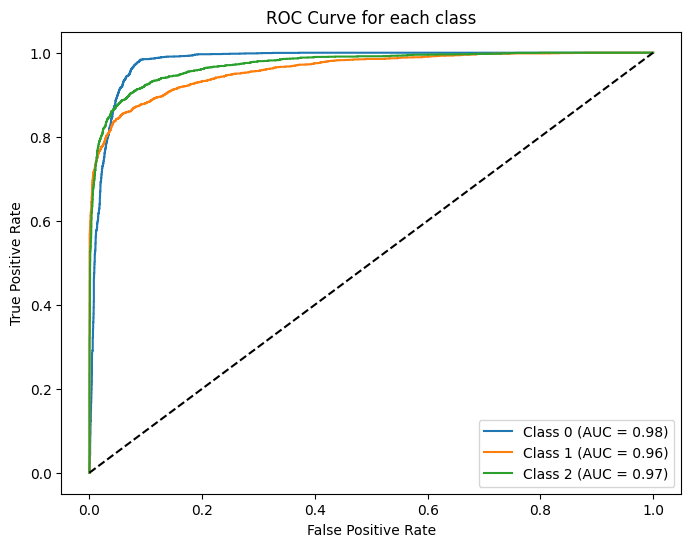

Overall AUC: 0.97


In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

model.eval()
true_labels = []
predicted_probs = []
with torch.no_grad():
    for data in tqdm(val_dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs.float())
        probs = torch.nn.functional.softmax(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        predicted_probs.extend(probs.cpu().numpy())

true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend()
plt.show()

# Compute overall AUC
overall_auc = np.mean(list(roc_auc.values()))
print(f'Overall AUC: {overall_auc:.2f}')